# Simulating the $\Phi^4$ theory on a quantum computer

In [1] and [2], algorithms for simulating lattice $\Phi^4$ scalar field lattice on a quantum computer was introduced. This can serve as a first example of simulating general lattice field theory on quantum computers.


The Hamiltonian under consideration is given by:

$$H(\Phi, \Pi) = \frac{1}{2}\Pi^2 + \frac{1}{2}m^2 \Phi^2 + \frac{1}{2}(\nabla \Phi)^2 + \frac{\lambda}{4!}\Phi^4 + J \Phi.$$

Here $\Phi$ and $\Pi$ satisfy the commutation relation:
$$[\Phi(x), \Pi(y)] = i\delta(x - y)$$

To simulate it on a quantum computer, we need to discretize it so that the lattice Hamiltonian takes the form:

$$H_{lat} = a^{D}\sum_{j=1}^N\left(\frac{1}{2}\Pi_j^2 + \frac{1}{2}m^2 \Phi_j^2 + \frac{1}{2a^2}\sum_{e=1}^{D}(\Phi_{j+e} - \Phi_{j})^2 + \frac{\lambda}{4!}\Phi_j^4 + J \Phi_j\right)$$

The lattice field operators satisfy:

$$[\Phi_i, \Pi_j] = ia^{-D}\delta_{i,j}$$

Rescaling with $\Phi_i \rightarrow a^{\frac{-D+1}{2}} \Phi_i $ and $\Pi_i \rightarrow a^{\frac{-D-1}{2}} \Pi_i $ makes the field and the conjugate momentum dimensionless.

In [ ]:
def get_qubit_label(in_site_label: int, site_label: int, n_phi_qubit: int) -> int:
    """Converts a local qubit index to the full system's qubit index.
    in_site_label: The qubit label on the local site.
    site_label: The label of the site.
    n_phi_qubit: Number of qubits assigned to each site.
    """
    return n_phi_qubit * site_label + in_site_label

In QURI Algo, we can define a subclass of `Problem` containing the parameters that characterize the system. So, we define `DiscreteScalarField1D` that represents the discrete scalar field Hamiltonian in 1 spatial dimension.

In [ ]:
from quri_algo.problem import QubitHamiltonian
from dataclasses import dataclass, field
import numpy as np

@dataclass
class DiscreteScalarField1D(QubitHamiltonian):
    """Represents the Hamiltonian of the 1D scalar field:

    Hamiltonian given by:
        H = 1/2 Π_j^2 + 1/2 mb^2 Φ_j^2 + 1/2 (Φ_j - Φ_{j+1})^2 + λ/4! Φ_j^4 + J_j Φ.

    Note:
        1D here means 1 spatial dimension.

    Args:
        n_state_qubit
        n_discretize: Number of points discretizing the field.
        n_phi_qubit: Number of qubits per site.
        mb: Boson mass.
        lam: coupling costant of the phi^4 term.
        external_field: External field strength J.
    """
    n_state_qubit: int = field(init=False)
    n_discretize: int
    n_phi_qubit: int
    mb: float
    lam: float
    external_field: float = 0.0

    def __post_init__(self) -> None:
        self.n_state_qubit = self.n_discretize * self.n_phi_qubit

    @property
    def n_phi_dimension(self) -> int:
        return 2**self.n_phi_qubit

    @property
    def delta_phi(self) -> float:
        return np.sqrt(2 * np.pi * self.mb / self.n_phi_dimension)

## Discrete scalar field

The discrete scalar field is designed to satisfy the quantization condition:

$$\Phi_j |\alpha_j \rangle = -\Delta_{\phi} \left(\alpha_j - \frac{N - 1}{2}\right)|\varphi_{\alpha_j} \rangle, \; \alpha_j = 0 \cdots N-1, $$

where $N = 2^n$ with $n$ being the number of qubits assigned to site $j$. The site index $j$ will be suppressed from now and we adopt the conventions:

$$
\begin{equation}
| \varphi_{\alpha_j} \rangle = | \alpha_{n-1} \cdots \alpha_{0} \rangle, \; \alpha = \sum_{q=0}^{n-1} \alpha_q 2^q.
\end{equation}
$$

The discrete field operator on the site $j$ can be expressed as:

$$\Phi = -\Delta_{\phi} \sum_{q=0}^{n-1}  2^{q-1} Z_q, \; \Delta_{\phi} = \sqrt{\frac{2\pi m_b}{N}}$$

which can be implemented as a QURI Parts `Operator`.

In [ ]:
from quri_parts.core.operator import Operator, pauli_label

def get_scalar_field_operator(
    site_label: int, n_phi_qubit: int, mass: float
) -> Operator:
    phi = Operator({})
    delta_phi = np.sqrt(2 * np.pi * mass / 2**n_phi_qubit)
    for q in range(n_phi_qubit):
        coeff = - delta_phi * 2**(q) / 2
        l = get_qubit_label(q, site_label, n_phi_qubit)
        phi.add_term(pauli_label(f"Z {l}"), coeff)
    return phi

##### Example: Check that the operator satisfies the field operator quantization condition.

In [ ]:
from quri_parts.core.state import quantum_state
from quri_parts.qulacs.estimator import create_qulacs_general_vector_estimator

site_label = 0
n_qubits = 4
mb = 1
estimator = create_qulacs_general_vector_estimator()

field_op = get_scalar_field_operator(site_label, n_qubits, mb)
b = 0b0101
estimator(field_op, quantum_state(n_qubits, bits=b)), (b - (2**n_qubits - 1)/2) * np.sqrt(2 * np.pi * mb / 2**n_qubits)

(_Estimate(value=(-1.5666426716443753+0j), error=0.0), -1.566642671644375)

## Discrete conjugate momentum

The discrete conjugate momentum is defined as 
$$
\begin{equation}
\Pi_j = m_b F_j \Phi_j F_j^{\dagger}
\end{equation}
$$
The $F_{j}$ terms is defined as ($j$ is suppressed.)

$$
F = \frac{1}{\sqrt{N}} \sum_{\alpha, \beta = 0}^{N-1} \exp\left[\frac{2\pi i}{N}(\alpha - \frac{N-1}{2})(\beta - \frac{N-1}{2})\right]|\beta\rangle\langle \alpha|
$$

The eigenstate of the conjugate momentum operator is defined as:

$$
|\kappa_\beta\rangle = F|\varphi_\beta\rangle,
$$

where $|\varphi_\beta\rangle$ is the eigenstate of the field operator $\Phi_j$ so that


$$
\Pi|\kappa_\beta\rangle = \left(\beta - \frac{N-1}{2}\right)|\kappa_\beta\rangle,
$$

The transformation $F$ is harder to be represented as a qubit operator. Instead, it can be represented as 

$$F = \left[\bigotimes_{p=0}^{n-1}R_Z(-2^p\delta)\right] \text{QFT} \left[\bigotimes_{q=0}^{n-1}R_Z(-2^q\delta)\right]$$

with $\delta \equiv \frac{(N-1)\pi}{N}$ and QFT corresponds to the quantum Fourier transform:

$$
\text{QFT}|\alpha \rangle = \frac{1}{\sqrt{N}}\sum_{\beta=0}^{N-1} \exp\left(\frac{2\pi i}{N}\alpha \beta \right)|\beta\rangle.
$$

### Quantum Fourier Transform

The quantum Fourier transform can be performed by the following circuit
![qft](qft_circuit.png)

where 
$$
U(k) = 
\begin{pmatrix}
1 & 0 \\
0 & \exp \left(\frac{2\pi i}{2^k}\right)
\end{pmatrix}
$$

and the controlled U gate can be decomposed into CNOTs and U gates as:

$$
CU_{c,t}(\theta) = U_{c}\left(\theta/2\right) CX_{c, t} \; U_{1, t}\left(-\theta/2\right) CX_{c, t} \; U_{1, t}\left(\theta/2\right).
$$

Here $c$ denotes the controlled qubit and $t$ denotes the target qubit. This can be implemented in QURI Parts as:

In [ ]:
from quri_parts.circuit import QuantumCircuit, NonParametricQuantumCircuit, ImmutableBoundParametricQuantumCircuit
import numpy as np

def add_controlled_U1_gate(
    circuit: QuantumCircuit, control: int, target: int, angle: float
) -> None:
    circuit.add_U1_gate(control, angle/2)
    circuit.add_CNOT_gate(control, target)
    circuit.add_U1_gate(target, -angle/2)
    circuit.add_CNOT_gate(control, target)
    circuit.add_U1_gate(target, angle/2)

Then the QFT circuit can be implemented with:

In [ ]:
def create_qft_gate(qubit_count: int) -> ImmutableBoundParametricQuantumCircuit:
    circuit = QuantumCircuit(qubit_count)
    for i in range(qubit_count//2):
        circuit.add_SWAP_gate(i, qubit_count-i-1)

    for target in range(qubit_count):
        circuit.add_H_gate(target)
        for l, control in enumerate(range(target+1, qubit_count)):
            angle = 2 * np.pi/2**(l+2)
            add_controlled_U1_gate(circuit, control, target, angle)

    return circuit.freeze()

##### Example: execute the quantum Fourier transform

In [ ]:
from quri_parts.qulacs.simulator import evaluate_state_to_vector

n_qubits = 4
n = 2**n_qubits
QFT = create_qft_gate(n_qubits)

for b in range(n):
    qft_state = quantum_state(n_qubits, circuit=QFT, bits=b)
    qft_state_vector = evaluate_state_to_vector(qft_state).vector

    expected_qft_vector = np.array([np.exp(2j * np.pi / n * i * b) for i in range(n)]) / np.sqrt(n)

    assert np.allclose(qft_state_vector, expected_qft_vector)

### The linear rotation term

Next, implement the linear rotation terms: $\bigotimes_{p=0}^{n-1}R_Z(-2^p\delta)$.

In [ ]:
def create_linear_rotation(qubit_count: int) -> ImmutableBoundParametricQuantumCircuit:
    circuit = QuantumCircuit(qubit_count)
    n = 2**qubit_count
    delta = (n - 1) * np.pi / n

    for q in range(qubit_count):
        angle = - 2**q * delta
        circuit.add_RZ_gate(q, angle)

    return circuit.freeze()

##### Example: the linear rotation term

In [ ]:
import itertools
n_qubits = 4
n = 2**n_qubits
linear_rotation = create_linear_rotation(n_qubits)

delta = (n - 1) / n * np.pi


for b1, b2 in itertools.product(range(n), repeat=2):

    linear_rotation_state_1 = quantum_state(n_qubits, circuit=linear_rotation, bits=b1)
    linear_rotation_vector_1 = evaluate_state_to_vector(linear_rotation_state_1).vector
    linear_rotation_state_2 = quantum_state(n_qubits, circuit=linear_rotation, bits=b2)
    linear_rotation_vector_2 = evaluate_state_to_vector(linear_rotation_state_2).vector

    n1 = linear_rotation_vector_1[linear_rotation_vector_1.nonzero()]
    n2 = linear_rotation_vector_2[linear_rotation_vector_2.nonzero()]

    assert np.isclose(
        n1/n2, np.exp(-1j * delta * (b1 - b2))
    )

### The $F$ operator

Finally, we can combine the functions in the last 2 subsections and finally implement the full circuit for the $F$ operation.

In [ ]:
def create_F_gate(qubit_count: int) -> NonParametricQuantumCircuit:
    circuit = QuantumCircuit(qubit_count)
    qft = create_qft_gate(qubit_count)
    linear_rotation = create_linear_rotation(qubit_count)

    circuit.extend(linear_rotation)
    circuit.extend(qft)
    circuit.extend(linear_rotation)

    return circuit

##### Example: full $F$ operator

In [ ]:
from quri_parts.qulacs.simulator import evaluate_state_to_vector

n_qubits = 4
N = 2**n_qubits
const = (N - 1)/2

F = create_F_gate(n_qubits)
b = 0b1001
conj_eig_state = quantum_state(n_qubits, circuit=F, bits=b)
conj_eig_state_vector = evaluate_state_to_vector(conj_eig_state).vector

expected = np.zeros(2**n_qubits, dtype=np.complex128)
for i in range(N):
    expected[i] = np.exp(
        2j * np.pi / N * (b - const) * (i - const)
    ) / np.sqrt(N)

expected / conj_eig_state_vector    # Only off by overall phase

array([-0.99518473+0.09801714j, -0.99518473+0.09801714j,
       -0.99518473+0.09801714j, -0.99518473+0.09801714j,
       -0.99518473+0.09801714j, -0.99518473+0.09801714j,
       -0.99518473+0.09801714j, -0.99518473+0.09801714j,
       -0.99518473+0.09801714j, -0.99518473+0.09801714j,
       -0.99518473+0.09801714j, -0.99518473+0.09801714j,
       -0.99518473+0.09801714j, -0.99518473+0.09801714j,
       -0.99518473+0.09801714j, -0.99518473+0.09801714j])

## The Exact Hamiltonian

Here we build the functions for generating the matrix representations of $\Phi_j$, $\Pi_j$, and the hamiltonian $H$ and the local hamiltonian $H_{local, j}$. These will be used extensively in later sections.

In [ ]:
import math
import functools
import numpy.typing as npt
from quri_parts.core.operator import get_sparse_matrix


def get_full_matrix(
    n_sites: int, phi_qubit: int, on_site_matrix: npt.NDArray[np.complex128], site_idx: int
) -> npt.NDArray[np.complex128]:
    """Expand an operator on a local site to a matrix of the whole system.
    """
    full = [np.eye(2 ** phi_qubit, dtype=np.complex128) for _ in range(n_sites)]
    full[n_sites - 1 - site_idx] = on_site_matrix
    return functools.reduce(lambda a, b: np.kron(a, b),  full)


def get_F_matrix(n_qubits: int) -> npt.NDArray[np.complex128]:
    """The matrix representation of the F operator on a single site.
    """
    dim = 2**n_qubits
    f_matrix = np.zeros((dim, dim), dtype=np.complex128)
    for a, b in itertools.product(range(dim), repeat=2):
        f_matrix[a, b] = np.exp(2j * np.pi/dim * (a - (dim - 1)/2) * (b - (dim - 1)/2))
    return f_matrix/np.sqrt(dim)


def get_phi_matrix(n_qubits: int, mass: float) -> npt.NDArray[np.complex128]:
    """The matrix representation of the field operator on a single site.
    """
    op = get_scalar_field_operator(0, n_qubits, mass)
    return get_sparse_matrix(op, n_qubits).toarray()


def get_hamiltonian_matrix(system: DiscreteScalarField1D) -> npt.NDArray[np.complex128]:
    """Matrix representation of full Hamiltonian.
    """
    n_qubits = system.n_phi_qubit
    n_site = system.n_discretize
    mb = system.mb
    J = system.external_field
    lam = system.lam
    F_matrix = get_F_matrix(n_qubits)
    phi = get_phi_matrix(n_qubits, mb)

    full_dim = 2**system.n_state_qubit
    hamiltonian = np.zeros((full_dim, full_dim), dtype=np.complex128)

    _phi_cache = {
        site: get_full_matrix(n_site, n_qubits, phi, site) for site in range(n_site)
    }
    for site in range(n_site):
        full_phi = _phi_cache[site]
        full_F = get_full_matrix(n_site, n_qubits, F_matrix, site)
        # conjugate momentum: mb^2 F Φ_j^2 F^{\dagger}
        hamiltonian += 0.5 * mb**2 * (full_F @ full_phi @ full_phi @ full_F.conj().T)

        # J Φ_j
        hamiltonian += J * full_phi

        # 1/2 mb^2 Φ_j^2
        hamiltonian += 0.5 * mb**2 * (full_phi @ full_phi)

        # lam/4! * Φ_j^4
        hamiltonian += (lam/math.factorial(4)) * (full_phi @ full_phi @ full_phi @ full_phi)

        # kin: 1/2 * (Φ_j - Φ_{j+1})^2
        if site < n_site - 1:
            kin_root = _phi_cache[site] - _phi_cache[site + 1]
            hamiltonian += 0.5 * kin_root @ kin_root
    return hamiltonian


def get_local_hamiltonian_matrix(system: DiscreteScalarField1D) -> npt.NDArray[np.complex128]:
    """Matrix representation of local Hamiltonian (on the zeroth site).
    """
    n_qubits = system.n_phi_qubit
    mb = system.mb
    J = system.external_field
    lam = system.lam
    F_matrix = get_F_matrix(n_qubits)
    phi = get_phi_matrix(n_qubits, mb)

    dim = 2**n_qubits
    hamiltonian = np.zeros((dim, dim), dtype=np.complex128)

    # conjugate momentum: mb^2 F Φ_j^2 F^{\dagger}
    hamiltonian += 0.5 * mb**2 * (F_matrix @ phi @ phi @ F_matrix.conj().T)

    # J Φ_j
    hamiltonian += J * phi

    # 1/2 mb^2 Φ_j^2
    hamiltonian += 0.5 * mb**2 * (phi @ phi)

    # lam/4! * Φ_j^4
    hamiltonian += (lam/math.factorial(4)) * (phi @ phi @ phi @ phi)

    return hamiltonian


## Local state preparation

As a demonstration, we prepare the ground state of the local Hamiltonian on site $j$:

$$H_{local, j} = \frac{1}{2}\Pi^2_{j} + \frac{1}{2}m^2 \Phi^2_j + \frac{\lambda}{4!}\Phi^4_j + J \Phi_j$$

with VQE. We assume the ansatz $|\psi(\vec{\theta})\rangle$ to be the Hardware Efficient Ansatz . The full wave function can then be prepared by:

$$|\Psi\rangle = \bigotimes_{j=0}^{N_{\text{site} -1}} |\psi_j(\vec{\theta}^*)\rangle$$

In [ ]:
import math
from quri_parts.algo.ansatz import HardwareEfficient
from quri_parts.algo.optimizer import CostFunction, Params
from quri_parts.qulacs.estimator import create_qulacs_general_vector_estimator
from quri_parts.core.state import ParametricCircuitQuantumState
from quri_parts.circuit import inverse_circuit

estimator = create_qulacs_general_vector_estimator()

def get_cost_function(system: DiscreteScalarField1D, n_layers: int) -> tuple[CostFunction, ParametricCircuitQuantumState]:

    n_local_qubit = system.n_phi_qubit

    F = create_F_gate(n_local_qubit)
    ansatz = HardwareEfficient(n_local_qubit, n_layers)
    ansatz_state = ParametricCircuitQuantumState(n_local_qubit, circuit=ansatz)

    scalar_field_op = get_scalar_field_operator(0, n_local_qubit, system.mb)

    def cost_function(param: Params) -> float:
        bound_state = ansatz_state.bind_parameters(param)
        transformed_state = bound_state.with_gates_applied(inverse_circuit(F))
        mb = system.mb
        lam = system.lam
        J = system.external_field

        # Π^2 = m^2 F Φ^2 F†
        # <Ψ| Π^2 |Ψ> = m^2 <Ψ|F Φ^2 F†|Ψ>
        pi_sq = estimator(0.5 * mb**2 * scalar_field_op * scalar_field_op, transformed_state)

        # 1/2 m^2 Φ^2 + lambda/4! Φ^4 + J Φ
        potential_op = 0.5 * mb**2 * scalar_field_op * scalar_field_op
        potential_op += (lam / math.factorial(4)) * scalar_field_op * scalar_field_op * scalar_field_op * scalar_field_op
        potential_op += J * scalar_field_op
        non_dyn = estimator(potential_op, bound_state)
        cost = pi_sq.value + non_dyn.value
        return cost.real

    return cost_function, ansatz_state

### Running the optimization loop

In [ ]:
from quri_parts.algo.optimizer import NFT, OptimizerState, Optimizer, OptimizerStatus

N_DISCRETIZE = 2
N_LOCAL_QUBIT = 4
MASS = 1.0
LAM = 1.0
system = DiscreteScalarField1D(N_DISCRETIZE, N_LOCAL_QUBIT, MASS, LAM,)

n_layers = 2

def vqe(cost: CostFunction, optimizer: Optimizer, init_param: Params) -> OptimizerState:
    it = 0
    opt_state = optimizer.get_init_state(init_param)
    while opt_state.status != OptimizerStatus.CONVERGED:
        opt_state = optimizer.step(opt_state, cost)
        it += 1
        print(f"{it}-th iteration", opt_state.cost)
    return opt_state

cost_fn, ansatz_state = get_cost_function(system, n_layers)
init_param = np.random.random(ansatz_state.parametric_circuit.parameter_count)
opt_result = vqe(cost_fn, NFT(), init_param)

1-th iteration 1.5149630657035198
2-th iteration 1.3570414047221697
3-th iteration 1.3458265324560763
4-th iteration 1.3437246180701101
5-th iteration 1.342633788950783


6-th iteration 1.3419101280151693
7-th iteration 1.3413990541889356
8-th iteration 1.3410308194876916
9-th iteration 1.3407609539962266
10-th iteration 1.340558734474652


11-th iteration 1.3404028617863892
12-th iteration 1.3402787172942934
13-th iteration 1.340176368495582
14-th iteration 1.340089119811582
15-th iteration 1.3400124794510904


16-th iteration 1.3399434356609596
17-th iteration 1.3398799576828258
18-th iteration 1.339820657313447
19-th iteration 1.3397645636718076
20-th iteration 1.3397109764585005


21-th iteration 1.339659372466516
22-th iteration 1.339609347232617
23-th iteration 1.3395605791264005
24-th iteration 1.3395128072499054
25-th iteration 1.3394658175206422


26-th iteration 1.3394194334377703
27-th iteration 1.3393735094677344
28-th iteration 1.3393279259050215
29-th iteration 1.3392825846163767
30-th iteration 1.3392374053852092


31-th iteration 1.3391923227305125
32-th iteration 1.3391472831450082
33-th iteration 1.339102242721705
34-th iteration 1.3390571651418766
35-th iteration 1.3390120199938773


36-th iteration 1.3389667813877368
37-th iteration 1.338921426828081
38-th iteration 1.3388759363076268
39-th iteration 1.3388302915853103


40-th iteration 1.3387844756165326
41-th iteration 1.338738472106688
42-th iteration 1.3386922651633477
43-th iteration 1.3386458390268172
44-th iteration 1.3385991778618034


45-th iteration 1.338552265596917
46-th iteration 1.3385050858009404
47-th iteration 1.3384576215873876
48-th iteration 1.3384098555406225
49-th iteration 1.3383617696583776


50-th iteration 1.3383133453067395
51-th iteration 1.3382645631844978
52-th iteration 1.338215403294676
53-th iteration 1.3381658449213927
54-th iteration 1.3381158666108892


55-th iteration 1.3380654461556993
56-th iteration 1.3380145605812461
57-th iteration 1.337963186134456
58-th iteration 1.3379112982738393
59-th iteration 1.3378588716610167


60-th iteration 1.3378058801532782
61-th iteration 1.3377522967971736
62-th iteration 1.3376980938230947
63-th iteration 1.337643242640637
64-th iteration 1.337587713834975


65-th iteration 1.3375314771640225
66-th iteration 1.337474501556512
67-th iteration 1.3374167551110518
68-th iteration 1.3373582050961126
69-th iteration 1.3372988179510752


70-th iteration 1.3372385592883587
71-th iteration 1.3371773938967284
72-th iteration 1.3371152857458248
73-th iteration 1.3370521979920473
74-th iteration 1.3369880929858018


75-th iteration 1.336922932280277
76-th iteration 1.336856676641841
77-th iteration 1.3367892860620756
78-th iteration 1.336720719771726


79-th iteration 1.3366509362564416
80-th iteration 1.3365798932746686
81-th iteration 1.3365075478775819
82-th iteration 1.336433856431341


83-th iteration 1.3363587746416807
84-th iteration 1.3362822575809656
85-th iteration 1.3362042597178618
86-th iteration 1.336124734949583
87-th iteration 1.3360436366370398


88-th iteration 1.3359609176426765
89-th iteration 1.335876530371306
90-th iteration 1.3357904268138003
91-th iteration 1.33570255859383
92-th iteration 1.3356128770175046


93-th iteration 1.3355213331259717
94-th iteration 1.3354278777509114
95-th iteration 1.335332461572819
96-th iteration 1.3352350351819138
97-th iteration 1.3351355491415884


98-th iteration 1.3350339540540914
99-th iteration 1.3349302006281727
100-th iteration 1.3348242397484695
101-th iteration 1.3347160225460728


102-th iteration 1.3346055004699269
103-th iteration 1.3344926253585208
104-th iteration 1.3343773495112299
105-th iteration 1.33425962575865
106-th iteration 1.3341394075311603


107-th iteration 1.3340166489248806
108-th iteration 1.3338913047640464
109-th iteration 1.333763330658852
110-th iteration 1.3336326830576168
111-th iteration 1.333499319292101


112-th iteration 1.3333631976147187
113-th iteration 1.3332242772262548
114-th iteration 1.3330825182927803
115-th iteration 1.3329378819501045
116-th iteration 1.3327903302943958


117-th iteration 1.3326398263572965
118-th iteration 1.3324863340638673
119-th iteration 1.332329818171784
120-th iteration 1.3321702441900078
121-th iteration 1.3320075782753487


122-th iteration 1.3318417871052106
123-th iteration 1.3316728377247806
124-th iteration 1.3315006973672536
125-th iteration 1.3313253332453703


126-th iteration 1.331146712312853
127-th iteration 1.3309648009943023
128-th iteration 1.3307795648823002
129-th iteration 1.330590968400419
130-th iteration 1.3303989744309828


131-th iteration 1.3302035439067452
132-th iteration 1.330004635365307
133-th iteration 1.3298022044656128
134-th iteration 1.3295962034657125
135-th iteration 1.3293865806611718


136-th iteration 1.3291732797833875
137-th iteration 1.3289562393572916
138-th iteration 1.3287353920178113
139-th iteration 1.3285106637843682
140-th iteration 1.328281973292754


141-th iteration 1.3280492309834362
142-th iteration 1.3278123382452356
143-th iteration 1.3275711865131927
144-th iteration 1.327325656318926
145-th iteration 1.327075616291554


146-th iteration 1.3268209221070448
147-th iteration 1.3265614153827878
148-th iteration 1.326296922514427
149-th iteration 1.3260272534506932
150-th iteration 1.3257522004015683


151-th iteration 1.3254715364744705
152-th iteration 1.3251850142318717
153-th iteration 1.3248923641633288
154-th iteration 1.3245932930633555
155-th iteration 1.3242874823058488


156-th iteration 1.3239745860042345
157-th iteration 1.323654229045023
158-th iteration 1.3233260049812354
159-th iteration 1.3229894737699155
160-th iteration 1.3226441593362523


161-th iteration 1.322289546944125
162-th iteration 1.3219250803505331
163-th iteration 1.3215501587175986
164-th iteration 1.32116413325237
165-th iteration 1.3207663035395742


166-th iteration 1.320355913526862
167-th iteration 1.3199321471148366
168-th iteration 1.3194941232955124
169-th iteration 1.3190408907715216
170-th iteration 1.3185714219750326


171-th iteration 1.3180846063876623
172-th iteration 1.317579243041359
173-th iteration 1.317054032052469
174-th iteration 1.3165075650070381
175-th iteration 1.3159383139718235


176-th iteration 1.3153446188504092
177-th iteration 1.3147246727347732
178-th iteration 1.3140765048146181
179-th iteration 1.3133979602958943
180-th iteration 1.312686676638861


181-th iteration 1.3119400552467695
182-th iteration 1.311155227507016
183-th iteration 1.310329013792937
184-th iteration 1.3094578736546225
185-th iteration 1.3085378449346734


186-th iteration 1.307564468898642
187-th iteration 1.3065326976162444
188-th iteration 1.3054367786890309
189-th iteration 1.3042701108797912
190-th iteration 1.303025062093686


191-th iteration 1.3016927382462347
192-th iteration 1.300262687463469
193-th iteration 1.2987225182405606
194-th iteration 1.2970574017813297
195-th iteration 1.2952494164159223


196-th iteration 1.2932766736167978
197-th iteration 1.2911121372477146
198-th iteration 1.2887220045621608
199-th iteration 1.2860634494268512


200-th iteration 1.2830814184825279
201-th iteration 1.2797039895933684
202-th iteration 1.2758354943779133
203-th iteration 1.2713460701531516
204-th iteration 1.266055342204992


205-th iteration 1.2597061475319984
206-th iteration 1.2519207814924815
207-th iteration 1.242125482134058
208-th iteration 1.2294152751494951
209-th iteration 1.2123044587869916


210-th iteration 1.188261967045551
211-th iteration 1.1529070639690504
212-th iteration 1.099164827055886
213-th iteration 1.0198728138662316
214-th iteration 0.9249611929714315


215-th iteration 0.8513364053064836
216-th iteration 0.8098988485955468
217-th iteration 0.7872861955237866
218-th iteration 0.7734341916584556


219-th iteration 0.763498334882033
220-th iteration 0.7553334517862683
221-th iteration 0.7478506521140013
222-th iteration 0.7404527170281239
223-th iteration 0.7328019117295511


224-th iteration 0.7246880523107297
225-th iteration 0.7159533042931229
226-th iteration 0.7064532172392595
227-th iteration 0.6960397141694601
228-th iteration 0.6845594491691641


229-th iteration 0.6718679110006174
230-th iteration 0.6578649264098768
231-th iteration 0.6425591767922264
232-th iteration 0.6261624381633542
233-th iteration 0.6091887880895226


234-th iteration 0.5924880731654874
235-th iteration 0.5771144630269762
236-th iteration 0.5640062579164964
237-th iteration 0.5536439928809014
238-th iteration 0.5459453814378075


239-th iteration 0.5404536862359994
240-th iteration 0.5366159039889848
241-th iteration 0.5339559544064307
242-th iteration 0.5321198586422524


243-th iteration 0.5308581344227497
244-th iteration 0.529996350514194
245-th iteration 0.5294118481543169
246-th iteration 0.5290181383139554
247-th iteration 0.5287545171051786


248-th iteration 0.5285788038585892
249-th iteration 0.5284620417967512
250-th iteration 0.5283845820227617
251-th iteration 0.5283332208676152
252-th iteration 0.5282991508574477


253-th iteration 0.5282765265257967
254-th iteration 0.5282614799961807
255-th iteration 0.5282514555477895
256-th iteration 0.5282447647274955
257-th iteration 0.528240291031197


We can compare the VQE state against the exact ground state of the local Hamiltonian

In [ ]:
from quri_algo.core.estimator.hadamard_test import shift_state_circuit
from quri_parts.qulacs.simulator import evaluate_state_to_vector
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigsh

local_state = ansatz_state.bind_parameters(opt_result.params)

local_state_vector = evaluate_state_to_vector(local_state).vector

local_hamiltonian_matrix = get_local_hamiltonian_matrix(system)
local_field_operator = get_scalar_field_operator(0, system.n_phi_qubit, system.mb)
local_field_operator_matrix = get_sparse_matrix(local_field_operator, system.n_phi_qubit)
sparse_local = csc_matrix(local_hamiltonian_matrix)
sparse_local.eliminate_zeros()

_, exact_local_gs_vec = eigsh(sparse_local, k=1, which="SA")
print(
    "Overlap with exact local Hamiltonian GS vector:",
    np.abs(exact_local_gs_vec.flatten().conj() @ local_state_vector)**2
)
print("------------------------------------------------------------")
print(
    "Exact GS energy:",
    (exact_local_gs_vec.conj().T @ local_hamiltonian_matrix @ exact_local_gs_vec)[0, 0].real
)
print("VQE energy:", cost_fn(opt_result.params))
print("------------------------------------------------------------")
print("Exact state <Φ0>:", np.round(exact_local_gs_vec.conj().T @ local_field_operator_matrix @ exact_local_gs_vec, 12)[0, 0].real)
print("VQE state <Φ0>:", estimator(local_field_operator, local_state).value.real)

Overlap with exact local Hamiltonian GS vector: 0.9999349943025017
------------------------------------------------------------
Exact GS energy: 0.5277361259588181
VQE energy: 0.5282402910312016
------------------------------------------------------------


Exact state <Φ0>: -0.0
VQE state <Φ0>: 7.46750566180407e-05


Now, we build a state for the full system, i.e.

$$|\Psi\rangle = \bigotimes_{j=0}^{N_{\text{site} -1}} |\psi_j(\vec{\theta}^*)\rangle$$

In [ ]:
init_state_circuit = QuantumCircuit(system.n_state_qubit)
for site in range(system.n_discretize):
    shift = site * system.n_phi_qubit
    local_circuit = shift_state_circuit(local_state.circuit, shift)
    init_state_circuit.extend(local_circuit)

INIT_STATE = quantum_state(system.n_state_qubit, circuit=init_state_circuit)

We may examine some properties of the prepared state

In [ ]:
from quri_parts.qulacs.simulator import evaluate_state_to_vector
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigsh
import itertools
import functools

init_state_vector = evaluate_state_to_vector(INIT_STATE).vector

full_hamiltonian = get_hamiltonian_matrix(system)
sparse_full = csc_matrix(full_hamiltonian)
sparse_full.eliminate_zeros()

exact_gs_energy, exact_gs_vec = eigsh(sparse_full, k=1, which="SA")


field_operator = functools.reduce(
    lambda a, b: a + b,
    [get_scalar_field_operator(n, system.n_phi_qubit, system.mb) for n in range(system.n_discretize)]
)
field_operator_matrix = get_sparse_matrix(field_operator).toarray()

print("Overlap with exact GS:", np.abs(exact_gs_vec.flatten().conj() @ init_state_vector)**2)
print("----------------------------------------------------------------")
print("Exact GS energy:", exact_gs_energy[0])
print("Prepared state <H>:", (init_state_vector.conj() @ full_hamiltonian @ init_state_vector).real)
print("----------------------------------------------------------------")
print("Exact <Φ>:", (exact_gs_vec.flatten().conj() @ field_operator_matrix @ exact_gs_vec).real[0])
print("Prepared <Φ>:", (init_state_vector.conj() @ field_operator_matrix @ init_state_vector).real)

Overlap with exact GS: 0.9720739298079517
----------------------------------------------------------------
Exact GS energy: 1.4021160736167078
Prepared state <H>: 1.5067423412222323
----------------------------------------------------------------
Exact <Φ>: 1.4051260155412137e-16
Prepared <Φ>: 0.00014935011323622543


There's a nonzero $\langle \Phi \rangle$ for the prepared state, so there should be non-trivial time evolution. The ground state with a non-trivial VEV needs to be prepared with adiabatic time evolution, which is not covered in this notebook, but is introduced in section IV of [1].

## Time Evolution

Here, we evolve the prepared state from the last section.

### Trotter time evolution

It is generally hard to build the exact time evolution due to the non-trivial commutator $[\Phi_i, \Pi_j]$. Usually, Trotterization is used to approximate the exact time evolution on a quantum computer:

$$
e^{-iHt} \approx \prod_{i=1}^{N}\prod_{j=0}^{N_{\text{site}}-1} e^{-\frac{i}{2}\Pi_j^2\frac{t}{N}} e^{-\frac{im^2}{2}\Phi_j^2\frac{t}{N}} e^{-\frac{i\lambda}{4!}\Phi_j^4\frac{t}{N}} e^{-iJ\Phi_j\frac{t}{N}} e^{-\frac{i}{2}(\Phi_j - \Phi_{j+1})^2\frac{t}{N}}
$$

In QURI Algo, circuit implementation of time evolution operators are represented by subclasses of `TimeEvolutionCircuitFactory`, where we build one for Trotterization implementation of the time evolution operator.

In [ ]:
import math
from quri_algo.circuit.time_evolution.interface import TimeEvolutionCircuitFactory
from quri_algo.circuit.utils.transpile import apply_transpiler
from quri_parts.circuit import NonParametricQuantumCircuit, LinearMappedUnboundParametricQuantumCircuit
from quri_parts.core.circuit import add_parametric_commuting_paulis_exp_gate

@dataclass
class DiscreteScalarFieldTrotterTimeEvoFactory(TimeEvolutionCircuitFactory):

    system: DiscreteScalarField1D
    n_trotter: int

    def __post_init__(self) -> None:
        self._evo_circuit = LinearMappedUnboundParametricQuantumCircuit(
            self.system.n_state_qubit
        )
        self._t = self._evo_circuit.add_parameter("t")
        self._construct_evolution_circuit()

    def field_operator(self, site_label: int) -> Operator:
        """The field operator on a given site.
        """
        return get_scalar_field_operator(
            site_label, self.system.n_phi_qubit, self.system.mb
        )

    def _construct_evolution_circuit(self) -> None:
        for _ in range(self.n_trotter):
            self._add_conj_momentum_square_evolution()
            self._add_ext_field_evolution()
            self._add_kinetic_evolution()
            self._add_phi_square_evolution()
            self._add_phi4_evolution()

    def _add_ext_field_evolution(self) -> NonParametricQuantumCircuit:
        """Add On site Φ_j^2 evolution term
        """
        J = self.system.external_field
        n_site = self.system.n_discretize
        for site in range(n_site):
            field_operator = self.field_operator(site)
            operator = J * field_operator
            add_parametric_commuting_paulis_exp_gate(
                self._evo_circuit, {self._t: -1.0/self.n_trotter}, operator,
            )

    def _add_phi_square_evolution(self) -> NonParametricQuantumCircuit:
        """Add On site Φ_j^2 evolution term
        """
        mb = self.system.mb
        n_site = self.system.n_discretize
        for site in range(n_site):
            field_operator = self.field_operator(site)
            operator = 0.5 * mb**2 * field_operator * field_operator
            add_parametric_commuting_paulis_exp_gate(
                self._evo_circuit, {self._t: -1.0/self.n_trotter}, operator,
            )

    def _add_conj_momentum_square_evolution(self) -> None:
        """On site Π_j^2 evolution term.
        """
        mb = self.system.mb
        f_gate = QuantumCircuit(
            self.system.n_state_qubit, gates=create_F_gate(n_qubits).gates
        )
        n_site = self.system.n_discretize
        n_site_qubit = self.system.n_phi_qubit
        for site in range(n_site):
            site_f = shift_state_circuit(f_gate, shift=site * n_site_qubit)
            inverse_f = inverse_circuit(site_f)
            field_operator = self.field_operator(site)
            operator = 0.5 * mb**2 * field_operator * field_operator
            self._evo_circuit.extend(inverse_f.gates)
            add_parametric_commuting_paulis_exp_gate(
                self._evo_circuit, {self._t: -1.0/self.n_trotter}, operator,
            )
            self._evo_circuit.extend(site_f.gates)

    def _add_phi4_evolution(self) -> None:
        """Add Φ_j^4 evolution term to circuit.
        """
        lam = self.system.lam
        n_site = self.system.n_discretize
        for site in range(n_site):
            field_operator = self.field_operator(site)
            operator = (lam / math.factorial(4)) * field_operator * field_operator * field_operator * field_operator
            add_parametric_commuting_paulis_exp_gate(
                self._evo_circuit, {self._t: -1.0/self.n_trotter}, operator,
            )

    def _add_kinetic_evolution(self) -> None:
        """Add (Φ_j - Φ_{j+1})^2 evolution term to circuit.
        """
        n_site = self.system.n_discretize
        for site in range(n_site - 1):
            field_operator = self.field_operator(site)
            next_field_operator = self.field_operator(site + 1)
            diff = next_field_operator - field_operator
            operator = 0.5 * diff * diff
            add_parametric_commuting_paulis_exp_gate(
                self._evo_circuit, {self._t: -1.0/self.n_trotter}, operator,
            )


    # @apply_transpiler
    def __call__(self, evolution_time: float) -> NonParametricQuantumCircuit:
        return self._evo_circuit.bind_parameters([evolution_time])


### Exact time evolution

We can also build one exact time evolution operator using one unitary matrix gate

In [ ]:
import functools
import numpy.typing as npt
from scipy.linalg import expm


@dataclass
class DiscreteScalarFieldExactTimeEvoFactory(TimeEvolutionCircuitFactory):

    system: DiscreteScalarField1D

    @functools.cached_property
    def hamiltonian_matrix(self) -> npt.NDArray[np.complex128]:
        return get_hamiltonian_matrix(self.system)

    def get_time_evolution_matrix(self, evolution_time: float) -> npt.NDArray[np.complex128]:
        return expm(-1j * evolution_time * self.hamiltonian_matrix)

    # @apply_transpiler
    def __call__(self, evolution_time: float) -> NonParametricQuantumCircuit:
        n_qubits = self.system.n_state_qubit
        evo = self.get_time_evolution_matrix(evolution_time)
        circuit = QuantumCircuit(self.system.n_state_qubit)
        circuit.add_UnitaryMatrix_gate(list(range(n_qubits)), evo)
        return circuit


### Execute the time evolution circuits

With all the components defined in the previous sections, we can build the time evolution circuit factories for both Trotter time evolution and exact time evolution.

In [ ]:
n_trotter = 10
trotter_evo_factory = DiscreteScalarFieldTrotterTimeEvoFactory(system, n_trotter=n_trotter)
exact_evo_factory = DiscreteScalarFieldExactTimeEvoFactory(system)


Here we look at the time dependence of the field operator $\Phi$. As explained in the state preparation section, it has a small but non-zero initial $\langle\Phi\rangle$, so we would expect $\Phi$ fluctuate with time with a small amplitude.

In [ ]:
import functools
field_operator = functools.reduce(
    lambda a, b: a + b,
    [get_scalar_field_operator(n, system.n_phi_qubit, system.mb) for n in range(system.n_discretize)]
)

In [ ]:
import tqdm

ts = np.linspace(0, 10, 101)

trotter_phi_exp_val = []
exact_phi_exp_val = []

for t in tqdm.tqdm(ts):
    trotter_evo = trotter_evo_factory(t)
    trotter_state = INIT_STATE.with_gates_applied(trotter_evo)
    trotter_phi_exp_val.append(estimator(field_operator, trotter_state).value.real)

    exact_evo = exact_evo_factory(t)
    exact_state = INIT_STATE.with_gates_applied(exact_evo)
    exact_phi_exp_val.append(estimator(field_operator, exact_state).value.real)

  0%|                                                                                                                                                                                                                                                                               | 0/101 [00:00<?, ?it/s]

  2%|█████▏                                                                                                                                                                                                                                                                 | 2/101 [00:00<00:17,  5.52it/s]

  3%|███████▊                                                                                                                                                                                                                                                               | 3/101 [00:00<00:19,  5.00it/s]

  4%|██████████▍                                                                                                                                                                                                                                                            | 4/101 [00:00<00:19,  5.02it/s]

  5%|█████████████                                                                                                                                                                                                                                                          | 5/101 [00:00<00:19,  4.90it/s]

  6%|███████████████▌                                                                                                                                                                                                                                                       | 6/101 [00:01<00:21,  4.50it/s]

  7%|██████████████████▏                                                                                                                                                                                                                                                    | 7/101 [00:01<00:25,  3.72it/s]

  8%|████████████████████▊                                                                                                                                                                                                                                                  | 8/101 [00:01<00:25,  3.59it/s]

  9%|███████████████████████▍                                                                                                                                                                                                                                               | 9/101 [00:02<00:25,  3.67it/s]

 10%|█████████████████████████▉                                                                                                                                                                                                                                            | 10/101 [00:02<00:24,  3.73it/s]

 11%|████████████████████████████▌                                                                                                                                                                                                                                         | 11/101 [00:02<00:24,  3.71it/s]

 12%|███████████████████████████████▏                                                                                                                                                                                                                                      | 12/101 [00:02<00:22,  3.92it/s]

 13%|█████████████████████████████████▋                                                                                                                                                                                                                                    | 13/101 [00:03<00:22,  3.95it/s]

 14%|████████████████████████████████████▎                                                                                                                                                                                                                                 | 14/101 [00:03<00:21,  4.05it/s]

 15%|██████████████████████████████████████▉                                                                                                                                                                                                                               | 15/101 [00:03<00:20,  4.20it/s]

 16%|█████████████████████████████████████████▌                                                                                                                                                                                                                            | 16/101 [00:03<00:20,  4.16it/s]

 17%|████████████████████████████████████████████                                                                                                                                                                                                                          | 17/101 [00:04<00:19,  4.40it/s]

 18%|██████████████████████████████████████████████▋                                                                                                                                                                                                                       | 18/101 [00:04<00:18,  4.43it/s]

 19%|█████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 19/101 [00:04<00:19,  4.24it/s]

 20%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                  | 20/101 [00:04<00:18,  4.39it/s]

 21%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                               | 21/101 [00:05<00:18,  4.31it/s]

 22%|█████████████████████████████████████████████████████████                                                                                                                                                                                                             | 22/101 [00:05<00:17,  4.61it/s]

 23%|███████████████████████████████████████████████████████████▋                                                                                                                                                                                                          | 23/101 [00:05<00:14,  5.23it/s]

 24%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 24/101 [00:05<00:14,  5.28it/s]

 25%|████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                     | 25/101 [00:05<00:16,  4.64it/s]

 26%|███████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 26/101 [00:06<00:17,  4.33it/s]

 27%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                                                | 27/101 [00:06<00:17,  4.26it/s]

 28%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                             | 28/101 [00:06<00:17,  4.09it/s]

 29%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                          | 29/101 [00:06<00:18,  3.85it/s]

 30%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 30/101 [00:07<00:19,  3.66it/s]

 31%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 31/101 [00:07<00:18,  3.72it/s]

 32%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                   | 32/101 [00:07<00:17,  3.96it/s]

 33%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                | 33/101 [00:07<00:17,  3.88it/s]

 34%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 34/101 [00:08<00:16,  3.99it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                           | 35/101 [00:08<00:16,  4.09it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                        | 36/101 [00:08<00:16,  3.97it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                      | 37/101 [00:08<00:14,  4.39it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 38/101 [00:09<00:13,  4.60it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                | 39/101 [00:09<00:14,  4.41it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 40/101 [00:09<00:12,  4.93it/s]

 41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 41/101 [00:09<00:12,  4.77it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 42/101 [00:09<00:12,  4.84it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 43/101 [00:10<00:12,  4.46it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 44/101 [00:10<00:14,  4.04it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 45/101 [00:10<00:13,  4.11it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 46/101 [00:10<00:13,  4.07it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 47/101 [00:11<00:13,  3.89it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 48/101 [00:11<00:14,  3.54it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 49/101 [00:11<00:14,  3.65it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 50/101 [00:11<00:13,  3.85it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 51/101 [00:12<00:11,  4.25it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 52/101 [00:12<00:11,  4.21it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 53/101 [00:12<00:11,  4.04it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 54/101 [00:12<00:10,  4.64it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 55/101 [00:13<00:10,  4.29it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 56/101 [00:13<00:11,  4.01it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 57/101 [00:13<00:10,  4.04it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 58/101 [00:13<00:10,  4.15it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 59/101 [00:14<00:10,  4.17it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 60/101 [00:14<00:09,  4.39it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 61/101 [00:14<00:09,  4.19it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 62/101 [00:14<00:09,  3.99it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 63/101 [00:15<00:09,  3.96it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 64/101 [00:15<00:09,  3.73it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 65/101 [00:15<00:09,  3.99it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 66/101 [00:15<00:10,  3.42it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 67/101 [00:16<00:09,  3.58it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 68/101 [00:16<00:08,  3.69it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 69/101 [00:16<00:08,  3.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 70/101 [00:17<00:09,  3.38it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 71/101 [00:17<00:08,  3.64it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/101 [00:17<00:07,  3.74it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 73/101 [00:17<00:06,  4.04it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 74/101 [00:18<00:06,  4.00it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 75/101 [00:18<00:06,  4.09it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 76/101 [00:18<00:06,  4.12it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 77/101 [00:18<00:05,  4.09it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 78/101 [00:19<00:05,  4.04it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 79/101 [00:19<00:05,  4.00it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 80/101 [00:19<00:05,  3.74it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 81/101 [00:19<00:05,  3.78it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 82/101 [00:20<00:05,  3.79it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 83/101 [00:20<00:04,  3.83it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 84/101 [00:20<00:04,  3.95it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 85/101 [00:20<00:04,  3.94it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 86/101 [00:21<00:03,  4.17it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 87/101 [00:21<00:03,  4.62it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 88/101 [00:21<00:03,  3.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 89/101 [00:21<00:02,  4.17it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 90/101 [00:21<00:02,  4.30it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 91/101 [00:22<00:02,  4.36it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 92/101 [00:22<00:02,  4.44it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 93/101 [00:22<00:01,  4.22it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 94/101 [00:22<00:01,  4.37it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 95/101 [00:23<00:01,  4.21it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 96/101 [00:23<00:01,  4.10it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 97/101 [00:23<00:00,  4.27it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 98/101 [00:23<00:00,  4.24it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 99/101 [00:24<00:00,  4.13it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 100/101 [00:24<00:00,  4.19it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:24<00:00,  4.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:24<00:00,  4.11it/s]

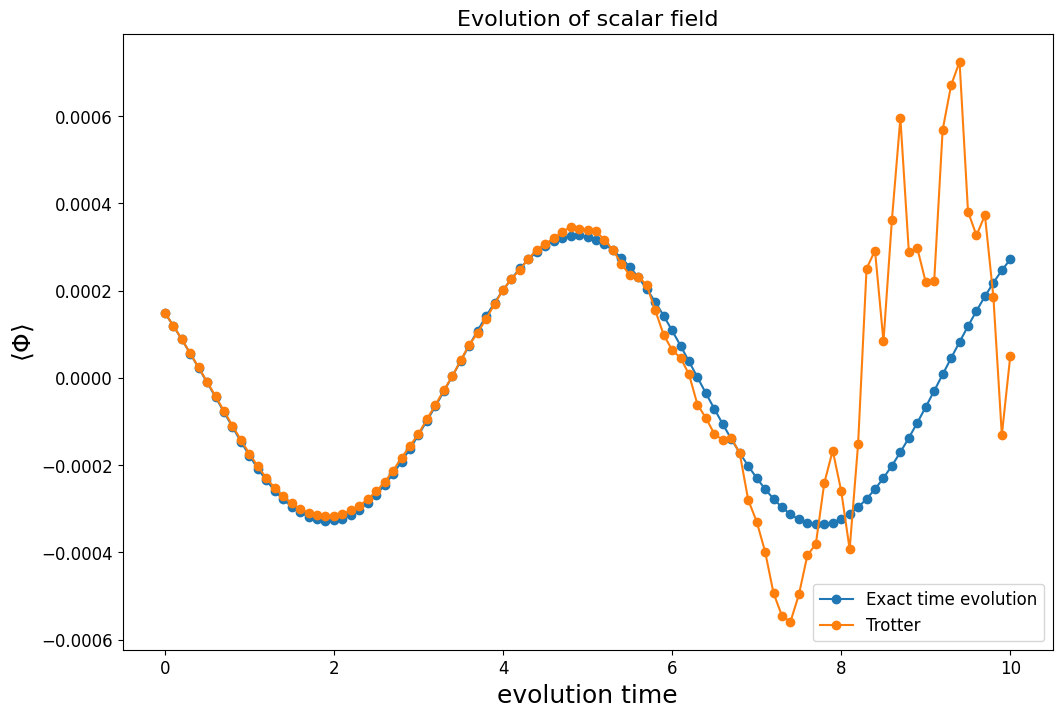

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 8)
plt.plot(ts, np.array(exact_phi_exp_val), "-o", label="Exact time evolution")
plt.plot(ts, np.array(trotter_phi_exp_val), "-o", label="Trotter")
plt.xlabel("evolution time", size=18)
plt.ylabel("$\\langle \\Phi \\rangle$", size=18)
plt.tick_params("both", labelsize=12)
plt.title("Evolution of scalar field", size=16)
plt.legend(fontsize=12, loc="lower right")
plt.show()


Here, we can see the that the exact time evolution curve suggests that the field operator oscillates around 0 with a small amplitude. The Trotter time evolution closely mimics the exact time evolution when the evolution time is small. After $t \geq 7$, the Trotter line behaves irregularly because the Trotter error begins to dominate. This can be fixed by using higher Trotter steps but comes at a price of deeper circuit, where noise from the quantum computer dominates over.

## Resource estimation

In the previous sections, we used a system of merely 2 sites and 4 qubits per site. While this is laptop-simulatable, it is very far from the realistic case where one would hope to have as many sites as possible and the subspace persite is as many as possible. Although this is not simulatable, we can still do resource estimation on how many resources a large scale simulation would take and how accurate the simulation can be on a given device or error correction architecture. Here, we use QURI VM for this purpose. Now we build a VM for square lattice superconducting NISQ device and another VM for STAR.

### NISQ device

For the square lattice NISQ device, we assume there is a $12 \times 12 = 144$ qubits device with basis gates being (`RZ`, `SqrtX`, `X`, `CNOT`). We further assume the 2-qubit gate error rate being $3 \times 10^{-3}$ and single qubit error rate being $5 \times 10^{-4}$.

In [ ]:
from quri_parts.backend.devices import nisq_spcond_lattice
from quri_parts.backend.units import TimeValue, TimeUnit
from quri_parts.circuit.topology.square_lattice import SquareLattice
from quri_vm import VM

square_lattice = SquareLattice(12, 12)

nisq_property = nisq_spcond_lattice.generate_device_property(
    lattice=square_lattice,
    native_gates_1q=("RZ", "SqrtX", "X"),
    native_gates_2q=("CNOT",),
    gate_error_1q=5e-4,
    gate_error_2q=3e-3,
    gate_error_meas=2e-2,
    gate_time_1q=TimeValue(60, TimeUnit.NANOSECOND),
    gate_time_2q=TimeValue(660, TimeUnit.NANOSECOND),
    gate_time_meas=TimeValue(1.4, TimeUnit.MICROSECOND)
)

nisq_vm = VM.from_device_prop(nisq_property)

### Partial error correction device: STAR architecture

Now, we build a VM for an error correction device based on the STAR architecture. This is a partial error correcting architecture introduced in [3]. We assume only 50 qubits are available to us, the code distance is 9 and the physical error rate is $p_{phys} = 10^{-4}$. The basis gates are `CNOT`, `RZ`, `H` and `S`, where the Clifford gates `CNOT`, `H` and `S` are fully error corrections and the `RZ` gate is subjected to logical error rate of:

$$P = 1 - \left(1 - \frac{2p_{phys}}{15}\right)^2.$$

In [ ]:
from quri_parts.backend.devices import star_device

logical_qubit_count = 50
p_phys = 1e-4
star_property = star_device.generate_device_property(
    logical_qubit_count,
    code_distance=9,
    qec_cycle=TimeValue(1, TimeUnit.MICROSECOND),
    physical_error_rate=p_phys
)
star_vm = VM.from_device_prop(star_property)

We first estimate the number of physical qubits needed to implement such device.

In [ ]:
print(f"{star_property.physical_qubit_count} physical qubits used to implement a device of 50 logical qubits and code distance 9.")

32400 physical qubits used to implement a device of 50 logical qubits and code distance 9.


### Resourse estimation: small scale 

Here, we evaluate the circuit execution time and circuit fidelity of the both the state preparation circuit and the time evolution circuit for the 8-qubit system used through out the previous sections.


#### State preparation

First, we start with the state preparation circuit. Recall that we used the 2-layer hardware efficient ansatz to perform the VQE computation. The 2-qubit gates in the hardware efficient ansatz only act on adjacent qubits, so is suitable to be executed on NISQ devices.

In [ ]:
from pprint import pprint

print("NISQ device analysis")
pprint(nisq_state_prep := nisq_vm.analyze(init_state_circuit))

print("----------------------------------------------------------------------------------")
print("STAR device analysis")
pprint(star_state_prep := star_vm.analyze(init_state_circuit))

NISQ device analysis
AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=8,
              gate_count=276,
              depth=51,
              latency=TimeValue(value=5460.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.8452801913024685)
----------------------------------------------------------------------------------
STAR device analysis
AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=8,
              gate_count=204,
              depth=30,
              latency=TimeValue(value=747000.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.9986859607354742)


As we can see above, the fidelity of the state preparation circuit on the NISQ device is about 84%, so we can expect the state preparation to be quite accurate even on today's devices with suitable error mitigation. For the STAR architecture, the circuit fidelity reaches fidelity over 99%. However, it comes at a price of execution time over 100 times. While execution time of a single circuit takes merely about 0.7 microseconds, the time of running the whole VQE loop will be magnified, which we will now estimate.

Recall that each call to the cost function involves 2 circuit execution, one pure 4-qubit hardware effecient circuit and the other 4-qubit hardware effecient circuit extended with an $F^{\dagger}$ operation.

In [ ]:
def estimate_vqe_time(
    vm: VM, system: DiscreteScalarField1D, vqe_result: OptimizerState, n_shots_per_iter: int
) -> tuple[TimeValue, float, float]:
    vqe_circuit = HardwareEfficient(system.n_phi_qubit, n_layers)
    conj_momentum_vqe_circuit = vqe_circuit + create_F_gate(system.n_phi_qubit)

    phi_analysis = vm.analyze(vqe_circuit)
    pi_analysis = vm.analyze(conj_momentum_vqe_circuit)

    one_call_time = phi_analysis.latency.in_ns() + pi_analysis.latency.in_ns()

    return (
        TimeValue(one_call_time * vqe_result.funcalls * 1e-9 * n_shots_per_iter, TimeUnit.SECOND),
        phi_analysis.fidelity,
        pi_analysis.fidelity,
    )

Assuming each iterations take $10^5$ shots

In [ ]:
n_shots = int(1e5)
nisq_vqe_time, nisq_phi_fid, nisq_pi_fid = estimate_vqe_time(nisq_vm, system, opt_result, n_shots)
star_vqe_time, star_phi_fid, star_pi_fid = estimate_vqe_time(star_vm, system, opt_result, n_shots)
print(
    f"""
    VQE takes {nisq_vqe_time.value / 3600: .3f} hours to be executed on NISQ device.
    (|Ψ> fidelity: {nisq_phi_fid}, F†|Ψ> fidelity: {nisq_pi_fid})
    """
)
print(
    f"""
    VQE takes {star_vqe_time.value / 3600: .3f} hours to be executed on STAR device.
    (|Ψ> fidelity: {star_phi_fid}, F†|Ψ> fidelity: {star_pi_fid})
    """
)


    VQE takes  25.789 hours to be executed on NISQ device.
    (|Ψ> fidelity: 0.9417291638110525, F†|Ψ> fidelity: 0.6746884636761388)
    

    VQE takes  388.399 hours to be executed on STAR device.
    (|Ψ> fidelity: 0.9999951651847668, F†|Ψ> fidelity: 0.9993389831048093)
    


Here, we can see that executing VQE on an error corrected device takes almost 20 times longer.

#### Time evolution

Next, we evaluate the time evolution circuit on both NISQ and STAR devices.

In [ ]:
print("NISQ device analysis")
pprint(nisq_vm.analyze(init_state_circuit + trotter_evo_factory(10)))

print("----------------------------------------------------------------------------------")
print("STAR device analysis")
pprint(star_vm.analyze(init_state_circuit + trotter_evo_factory(10)))

NISQ device analysis


AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=8,
              gate_count=18326,
              depth=10594,
              latency=TimeValue(value=6602760.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=2.2073225801174015e-21)
----------------------------------------------------------------------------------
STAR device analysis
AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=8,
              gate_count=4344,
              depth=1324,
              latency=TimeValue(value=30807000.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.9638181279070184)


As shown in the results above, the fidelity of running the time evolution circuit on a NISQ device is close to 0 while the fidelity on STAR device remains over 96%. This gives error corrected device major advantage for simulating the scalar field theory.

### Resource estimation: large scale 

The previous section serves as a toy example of cost estimation. We now move to large scale systems that is not laptop-simulatable and estimate the cost like we did in the last section. We discretize the scalar field to 8 sites and each site contains 6 qubits. This gives as 48 logical qubits in total and is almost the maximal size the STAR device can hold.

In [ ]:
large_system = DiscreteScalarField1D(n_discretize=8, n_phi_qubit=6, mb=1, lam=1)

#### State preparation cost

As in the small scale section, we first estimate the fidelity and execution time of the initial state circuit and estimate the cost of executing VQE.

In [ ]:
large_vqe_ansatz = HardwareEfficient(large_system.n_phi_qubit, reps=2)
large_vqe_circuit = large_vqe_ansatz.bind_parameters(np.random.random(large_vqe_ansatz.parameter_count))

large_init_circuit = QuantumCircuit(large_system.n_state_qubit)
for site in range(large_system.n_discretize):
    shift = site * large_system.n_phi_qubit
    large_init_circuit.extend(shift_state_circuit(large_vqe_circuit, shift).gates)

large_init_circuit

In [ ]:
pprint("NISQ device analysis")
pprint(nisq_vm.analyze(large_init_circuit))

print("----------------------------------------------------------------------------------")
pprint("STAR device analysis")
pprint(star_vm.analyze(large_init_circuit))

'NISQ device analysis'
AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=48,
              gate_count=1776,
              depth=51,
              latency=TimeValue(value=5460.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.3366966870560188)
----------------------------------------------------------------------------------
'STAR device analysis'
AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=48,
              gate_count=1248,
              depth=30,
              latency=TimeValue(value=747000.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.992141619566363)


Next, we again estimate the cost of running VQE.

In [ ]:
n_shots = int(1e5)
large_nisq_vqe_time, large_nisq_phi_fid, large_nisq_pi_fid = estimate_vqe_time(nisq_vm, large_system, opt_result, n_shots)
large_star_vqe_time, large_star_phi_fid, large_star_pi_fid = estimate_vqe_time(star_vm, large_system, opt_result, n_shots)
print(
    f"""
    VQE takes {large_nisq_vqe_time.value / 3600: .3f} hours to be executed on NISQ device.
    (|Ψ> fidelity: {large_nisq_phi_fid}, F†|Ψ> fidelity: {large_nisq_pi_fid})
    """
)
print(
    f"""
    VQE takes {large_star_vqe_time.value / 3600: .3f} hours to be executed on STAR device.
    (|Ψ> fidelity: {large_star_phi_fid}, F†|Ψ> fidelity: {large_star_pi_fid})
    """
)


    VQE takes  85.072 hours to be executed on NISQ device.
    (|Ψ> fidelity: 0.9047807805707612, F†|Ψ> fidelity: 0.2691948085794522)
    

    VQE takes  538.747 hours to be executed on STAR device.
    (|Ψ> fidelity: 0.999992747785916, F†|Ψ> fidelity: 0.9984874866534053)
    


### Time evolution circuit

Finally, we evaluate the fidelity of the time evolution circuit.

In [ ]:
trotter_step = 10
large_time_evolution_factory = DiscreteScalarFieldTrotterTimeEvoFactory(large_system, trotter_step)
evo_circuit = large_time_evolution_factory(evolution_time=1.0)

In [ ]:
print("NISQ device analysis")
pprint(nisq_vm.analyze(evo_circuit))

print("----------------------------------------------------------------------------------")
print("STAR device analysis")
pprint(star_vm.analyze(evo_circuit))

NISQ device analysis


AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=48,
              gate_count=369060,
              depth=100168,
              latency=TimeValue(value=65684280.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=8.2e-322)
----------------------------------------------------------------------------------
STAR device analysis


AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=48,
              gate_count=41060,
              depth=3028,
              latency=TimeValue(value=69984000.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.6885154917215952)


This shows that simulating a 48 qubit time evolution with Trotterization is practically impossible, and we need to resort to an error correcting device for better fidelity.

## Hilbert-Schmidt test

While the field operator expectation value for short evolution times closely follows the exact time evolution as seen above, we can confirm that the time-evolution operator as a whole is faithful to this behaviour by evaluating the Hilbert-Schmidt test

$$
    C_\textup{HST}(U,V) = 1 - \frac{1}{4^{N_q}} |\textup{Tr}[U^\dagger V]|^2.
$$

The rightmost term above, the Hilbert-Schmidt product, is equivalent to the average fidelity of two copies of a Haar random state undergoing unitary rotation by $U$ and $V$.

QURI Algo let's us do this with ease. What we need is to import the `HilberSchmidtTest` class from `quri_algo.core.cost_functions` module

In [ ]:
import tqdm
from quri_algo.core.cost_functions import HilbertSchmidtTest

hs_test = HilbertSchmidtTest(
    estimator, alpha=1.0  # This alpha interpolates between the local and global HS tests
)
lhs_test = HilbertSchmidtTest(
    estimator, alpha=0.0
)

ts = np.linspace(0, 10, 101)
hs_cost = []
lhs_cost = []

for t in tqdm.tqdm(ts):
    trotter_evo = trotter_evo_factory(t)
    trotter_state = INIT_STATE.with_gates_applied(trotter_evo)

    exact_evo = exact_evo_factory(t)
    exact_state = INIT_STATE.with_gates_applied(exact_evo)

    hs_cost.append(hs_test(exact_state.circuit, trotter_state.circuit).value.real)
    lhs_cost.append(lhs_test(exact_state.circuit, trotter_state.circuit).value.real)

  0%|                                                                                        | 0/101 [00:00<?, ?it/s]

  1%|▊                                                                               | 1/101 [00:05<08:49,  5.30s/it]

  2%|█▌                                                                              | 2/101 [00:07<06:06,  3.70s/it]

  3%|██▍                                                                             | 3/101 [00:10<05:15,  3.22s/it]

  4%|███▏                                                                            | 4/101 [00:13<04:54,  3.03s/it]

  5%|███▉                                                                            | 5/101 [00:15<04:36,  2.88s/it]

  6%|████▊                                                                           | 6/101 [00:18<04:34,  2.89s/it]

  7%|█████▌                                                                          | 7/101 [00:21<04:21,  2.78s/it]

  8%|██████▎                                                                         | 8/101 [00:23<04:14,  2.73s/it]

  9%|███████▏                                                                        | 9/101 [00:26<04:06,  2.68s/it]

 10%|███████▊                                                                       | 10/101 [00:29<04:01,  2.65s/it]

 11%|████████▌                                                                      | 11/101 [00:32<04:14,  2.83s/it]

 12%|█████████▍                                                                     | 12/101 [00:34<04:04,  2.75s/it]

 13%|██████████▏                                                                    | 13/101 [00:37<03:59,  2.72s/it]

 14%|██████████▉                                                                    | 14/101 [00:40<04:01,  2.78s/it]

 15%|███████████▋                                                                   | 15/101 [00:43<03:54,  2.72s/it]

 16%|████████████▌                                                                  | 16/101 [00:46<04:05,  2.89s/it]

 17%|█████████████▎                                                                 | 17/101 [00:49<03:57,  2.82s/it]

 18%|██████████████                                                                 | 18/101 [00:51<03:46,  2.73s/it]

 19%|██████████████▊                                                                | 19/101 [00:54<03:38,  2.67s/it]

 20%|███████████████▋                                                               | 20/101 [00:56<03:32,  2.63s/it]

 21%|████████████████▍                                                              | 21/101 [00:59<03:43,  2.79s/it]

 22%|█████████████████▏                                                             | 22/101 [01:02<03:37,  2.75s/it]

 23%|█████████████████▉                                                             | 23/101 [01:05<03:34,  2.76s/it]

 24%|██████████████████▊                                                            | 24/101 [01:07<03:29,  2.72s/it]

 25%|███████████████████▌                                                           | 25/101 [01:10<03:22,  2.66s/it]

 26%|████████████████████▎                                                          | 26/101 [01:13<03:32,  2.84s/it]

 27%|█████████████████████                                                          | 27/101 [01:16<03:28,  2.81s/it]

 28%|█████████████████████▉                                                         | 28/101 [01:19<03:26,  2.84s/it]

 29%|██████████████████████▋                                                        | 29/101 [01:21<03:20,  2.78s/it]

 30%|███████████████████████▍                                                       | 30/101 [01:24<03:14,  2.74s/it]

 31%|████████████████████████▏                                                      | 31/101 [01:27<03:20,  2.87s/it]

 32%|█████████████████████████                                                      | 32/101 [01:30<03:16,  2.85s/it]

 33%|█████████████████████████▊                                                     | 33/101 [01:33<03:10,  2.81s/it]

 34%|██████████████████████████▌                                                    | 34/101 [01:35<03:02,  2.72s/it]

 35%|███████████████████████████▍                                                   | 35/101 [01:38<02:57,  2.69s/it]

 36%|████████████████████████████▏                                                  | 36/101 [01:41<02:53,  2.68s/it]

 37%|████████████████████████████▉                                                  | 37/101 [01:44<02:59,  2.80s/it]

 38%|█████████████████████████████▋                                                 | 38/101 [01:46<02:51,  2.72s/it]

 39%|██████████████████████████████▌                                                | 39/101 [01:49<02:48,  2.72s/it]

 40%|███████████████████████████████▎                                               | 40/101 [01:52<02:47,  2.75s/it]

 41%|████████████████████████████████                                               | 41/101 [01:54<02:44,  2.75s/it]

 42%|████████████████████████████████▊                                              | 42/101 [01:58<02:48,  2.86s/it]

 43%|█████████████████████████████████▋                                             | 43/101 [02:00<02:43,  2.82s/it]

 44%|██████████████████████████████████▍                                            | 44/101 [02:03<02:39,  2.79s/it]

 45%|███████████████████████████████████▏                                           | 45/101 [02:06<02:34,  2.76s/it]

 46%|███████████████████████████████████▉                                           | 46/101 [02:09<02:34,  2.81s/it]

 47%|████████████████████████████████████▊                                          | 47/101 [02:12<02:39,  2.96s/it]

 48%|█████████████████████████████████████▌                                         | 48/101 [02:15<02:33,  2.89s/it]

 49%|██████████████████████████████████████▎                                        | 49/101 [02:17<02:25,  2.80s/it]

 50%|███████████████████████████████████████                                        | 50/101 [02:20<02:20,  2.76s/it]

 50%|███████████████████████████████████████▉                                       | 51/101 [02:22<02:15,  2.71s/it]

 51%|████████████████████████████████████████▋                                      | 52/101 [02:26<02:20,  2.86s/it]

 52%|█████████████████████████████████████████▍                                     | 53/101 [02:29<02:16,  2.85s/it]

 53%|██████████████████████████████████████████▏                                    | 54/101 [02:31<02:09,  2.77s/it]

 54%|███████████████████████████████████████████                                    | 55/101 [02:34<02:05,  2.74s/it]

 55%|███████████████████████████████████████████▊                                   | 56/101 [02:36<02:02,  2.73s/it]

 56%|████████████████████████████████████████████▌                                  | 57/101 [02:39<01:58,  2.70s/it]

 57%|█████████████████████████████████████████████▎                                 | 58/101 [02:43<02:11,  3.07s/it]

 58%|██████████████████████████████████████████████▏                                | 59/101 [02:46<02:03,  2.94s/it]

 59%|██████████████████████████████████████████████▉                                | 60/101 [02:48<01:56,  2.85s/it]

 60%|███████████████████████████████████████████████▋                               | 61/101 [02:51<01:50,  2.77s/it]

 61%|████████████████████████████████████████████████▍                              | 62/101 [02:54<01:47,  2.76s/it]

 62%|█████████████████████████████████████████████████▎                             | 63/101 [02:57<01:49,  2.89s/it]

 63%|██████████████████████████████████████████████████                             | 64/101 [02:59<01:42,  2.78s/it]

 64%|██████████████████████████████████████████████████▊                            | 65/101 [03:02<01:38,  2.74s/it]

 65%|███████████████████████████████████████████████████▌                           | 66/101 [03:05<01:33,  2.67s/it]

 66%|████████████████████████████████████████████████████▍                          | 67/101 [03:07<01:32,  2.72s/it]

 67%|█████████████████████████████████████████████████████▏                         | 68/101 [03:11<01:35,  2.89s/it]

 68%|█████████████████████████████████████████████████████▉                         | 69/101 [03:13<01:30,  2.82s/it]

 69%|██████████████████████████████████████████████████████▊                        | 70/101 [03:16<01:25,  2.75s/it]

 70%|███████████████████████████████████████████████████████▌                       | 71/101 [03:19<01:21,  2.73s/it]

 71%|████████████████████████████████████████████████████████▎                      | 72/101 [03:21<01:19,  2.76s/it]

 72%|█████████████████████████████████████████████████████████                      | 73/101 [03:24<01:20,  2.86s/it]

 73%|█████████████████████████████████████████████████████████▉                     | 74/101 [03:27<01:15,  2.80s/it]

 74%|██████████████████████████████████████████████████████████▋                    | 75/101 [03:30<01:11,  2.75s/it]

 75%|███████████████████████████████████████████████████████████▍                   | 76/101 [03:33<01:09,  2.77s/it]

 76%|████████████████████████████████████████████████████████████▏                  | 77/101 [03:35<01:05,  2.71s/it]

 77%|█████████████████████████████████████████████████████████████                  | 78/101 [03:38<01:01,  2.66s/it]

 78%|█████████████████████████████████████████████████████████████▊                 | 79/101 [03:41<01:01,  2.80s/it]

 79%|██████████████████████████████████████████████████████████████▌                | 80/101 [03:43<00:57,  2.75s/it]

 80%|███████████████████████████████████████████████████████████████▎               | 81/101 [03:46<00:54,  2.72s/it]

 81%|████████████████████████████████████████████████████████████████▏              | 82/101 [03:49<00:51,  2.73s/it]

 82%|████████████████████████████████████████████████████████████████▉              | 83/101 [03:52<00:49,  2.76s/it]

 83%|█████████████████████████████████████████████████████████████████▋             | 84/101 [03:55<00:49,  2.90s/it]

 84%|██████████████████████████████████████████████████████████████████▍            | 85/101 [03:58<00:45,  2.84s/it]

 85%|███████████████████████████████████████████████████████████████████▎           | 86/101 [04:00<00:41,  2.80s/it]

 86%|████████████████████████████████████████████████████████████████████           | 87/101 [04:03<00:38,  2.77s/it]

 87%|████████████████████████████████████████████████████████████████████▊          | 88/101 [04:06<00:35,  2.70s/it]

 88%|█████████████████████████████████████████████████████████████████████▌         | 89/101 [04:09<00:33,  2.82s/it]

 89%|██████████████████████████████████████████████████████████████████████▍        | 90/101 [04:11<00:30,  2.76s/it]

 90%|███████████████████████████████████████████████████████████████████████▏       | 91/101 [04:14<00:27,  2.74s/it]

 91%|███████████████████████████████████████████████████████████████████████▉       | 92/101 [04:17<00:24,  2.72s/it]

 92%|████████████████████████████████████████████████████████████████████████▋      | 93/101 [04:19<00:21,  2.69s/it]

 93%|█████████████████████████████████████████████████████████████████████████▌     | 94/101 [04:22<00:19,  2.72s/it]

 94%|██████████████████████████████████████████████████████████████████████████▎    | 95/101 [04:25<00:16,  2.83s/it]

 95%|███████████████████████████████████████████████████████████████████████████    | 96/101 [04:28<00:13,  2.76s/it]

 96%|███████████████████████████████████████████████████████████████████████████▊   | 97/101 [04:31<00:11,  2.79s/it]

 97%|████████████████████████████████████████████████████████████████████████████▋  | 98/101 [04:33<00:08,  2.76s/it]

 98%|█████████████████████████████████████████████████████████████████████████████▍ | 99/101 [04:36<00:05,  2.74s/it]

 99%|█████████████████████████████████████████████████████████████████████████████▏| 100/101 [04:39<00:02,  2.88s/it]

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [04:42<00:00,  2.80s/it]

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [04:42<00:00,  2.80s/it]

We will plot the cost-function below for each time-step

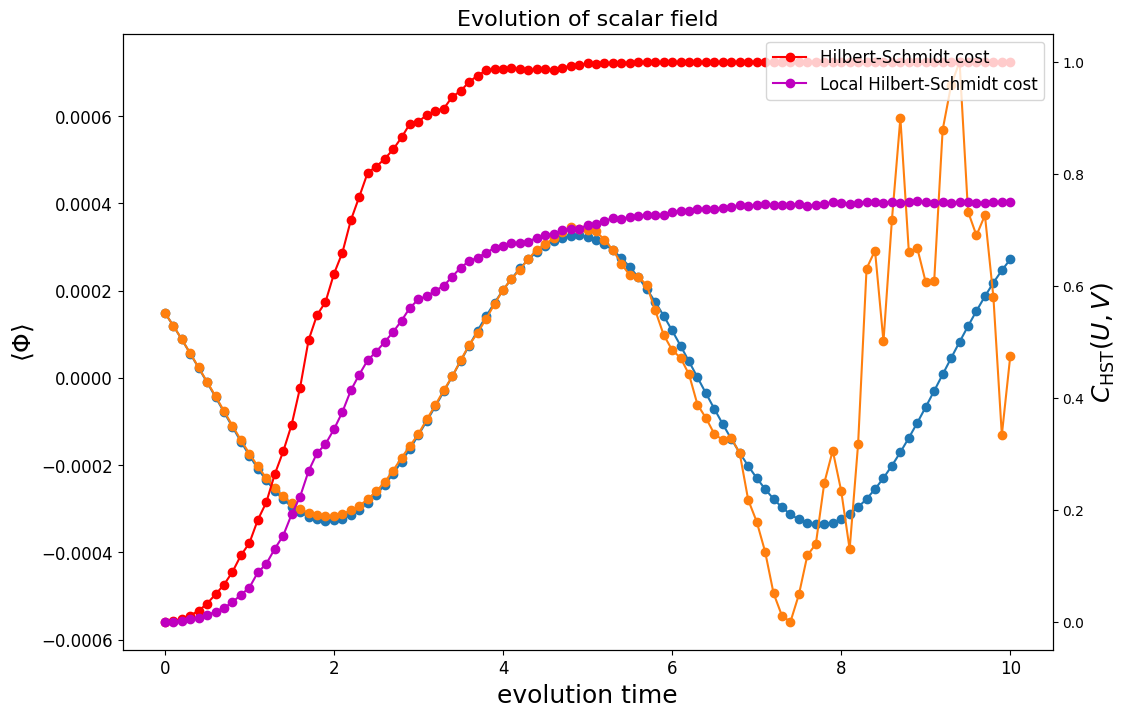

In [ ]:

plt.rcParams["figure.figsize"] = (12, 8)
plt.plot(ts, np.array(exact_phi_exp_val), "-o", label="Exact time evolution")
plt.plot(ts, np.array(trotter_phi_exp_val), "-o", label="Trotter")
plt.xlabel("evolution time", size=18)
plt.ylabel("$\\langle \\Phi \\rangle$", size=18)
plt.tick_params("both", labelsize=12)
plt.title("Evolution of scalar field", size=16)
plt.twinx()
plt.plot(ts, np.array(hs_cost), "-or", label="Hilbert-Schmidt cost")
plt.plot(ts, np.array(lhs_cost), "-om", label="Local Hilbert-Schmidt cost")
plt.ylabel("$C_\\text{HST}(U,V)$", size=18)
plt.legend(fontsize=12, loc="upper right")
plt.show()

Evidently, the fidelity of two unitaries is a much stricter condition for accurate time-evolution compared to the operator expectation value - and this makes sense since the expectation value of a quantum operator with respect to a pure state is only sensitive to a single state, whereas the Hilbert-Schmidt product is a state averaged quantity over the whole Hilbert space!

Does the situation change if we use the local Hilbert-Schmidt test? Well, to some extent the local Hilbert-Schmidt cost is lower. This is because it is an average over local cost-functions that each only depend on the resulting density matrix of a single pair of qubits. Here each of these local cost functions measure whether those qubit pairs can be disentangled or by a local operation. This defines the entanglement fidelity, which is weighted equally for each pair. In contrast, for the global Hilbert-Schmidt cost to be significantly lower than unity every qubit pair must simultaneously be disentangled.

The main take-away is that the two cost-functions, the local and the global Hilbert-Schmidt tests in general do not have the same inflection point, and in general for larger systems the local Hilbert Schmidt test will be smoother, whereas the Hilbert-Schmidt product for the global one will be exponentially suppressed. Thus for larger qubit systems the local one is preferred as it is more likely to have non-zero gradients when used as a cost-function

### Can we improve it by adding more Trotter steps?

Let's try with more Trotter steps and see if the situation improves. We will add several Trotter steps below and evaluate the Hilbert-Schmidt cost of each circuit. For the evaluation we will compare with the exact time-evolution unitary.

In [ ]:

trotter_steps = [20, 30, 40, 50, 60]
exact_evo_factory = DiscreteScalarFieldExactTimeEvoFactory(system)

hs_cost_lists= []

for i, n_trotter in enumerate(tqdm.tqdm(trotter_steps)):
    trotter_evo_factory = DiscreteScalarFieldTrotterTimeEvoFactory(system, n_trotter)
    hs_cost_lists.append([])
    for t in tqdm.tqdm(ts):
        trotter_evo = trotter_evo_factory(t)
        trotter_state = INIT_STATE.with_gates_applied(trotter_evo)

        exact_evo = exact_evo_factory(t)
        exact_state = INIT_STATE.with_gates_applied(exact_evo)

        hs_cost_lists[i].append(hs_test(exact_state.circuit, trotter_state.circuit).value.real)

  0%|                                                                                          | 0/5 [00:00<?, ?it/s]

  0%|                                                                                        | 0/101 [00:00<?, ?it/s]

  1%|▊                                                                               | 1/101 [00:02<04:10,  2.51s/it]

  2%|█▌                                                                              | 2/101 [00:05<04:07,  2.50s/it]

  3%|██▍                                                                             | 3/101 [00:07<04:08,  2.53s/it]

  4%|███▏                                                                            | 4/101 [00:10<04:30,  2.79s/it]

  5%|███▉                                                                            | 5/101 [00:13<04:22,  2.74s/it]

  6%|████▊                                                                           | 6/101 [00:16<04:17,  2.71s/it]

  7%|█████▌                                                                          | 7/101 [00:18<04:12,  2.69s/it]

  8%|██████▎                                                                         | 8/101 [00:21<04:08,  2.67s/it]

  9%|███████▏                                                                        | 9/101 [00:24<04:15,  2.78s/it]

 10%|███████▊                                                                       | 10/101 [00:26<04:08,  2.73s/it]

 11%|████████▌                                                                      | 11/101 [00:29<03:59,  2.67s/it]

 12%|█████████▍                                                                     | 12/101 [00:32<03:55,  2.65s/it]

 13%|██████████▏                                                                    | 13/101 [00:34<03:54,  2.67s/it]

 14%|██████████▉                                                                    | 14/101 [00:38<04:11,  2.89s/it]

 15%|███████████▋                                                                   | 15/101 [00:40<04:01,  2.80s/it]

 16%|████████████▌                                                                  | 16/101 [00:43<03:48,  2.69s/it]

 17%|█████████████▎                                                                 | 17/101 [00:46<03:50,  2.74s/it]

 18%|██████████████                                                                 | 18/101 [00:49<03:58,  2.87s/it]

 19%|██████████████▊                                                                | 19/101 [00:51<03:45,  2.75s/it]

 20%|███████████████▋                                                               | 20/101 [00:54<03:55,  2.90s/it]

 21%|████████████████▍                                                              | 21/101 [00:57<03:42,  2.78s/it]

 22%|█████████████████▏                                                             | 22/101 [00:59<03:29,  2.65s/it]

 23%|█████████████████▉                                                             | 23/101 [01:02<03:24,  2.62s/it]

 24%|██████████████████▊                                                            | 24/101 [01:04<03:20,  2.61s/it]

 25%|███████████████████▌                                                           | 25/101 [01:08<03:31,  2.79s/it]

 26%|████████████████████▎                                                          | 26/101 [01:10<03:22,  2.70s/it]

 27%|█████████████████████                                                          | 27/101 [01:13<03:15,  2.65s/it]

 28%|█████████████████████▉                                                         | 28/101 [01:15<03:10,  2.61s/it]

 29%|██████████████████████▋                                                        | 29/101 [01:18<03:06,  2.59s/it]

 30%|███████████████████████▍                                                       | 30/101 [01:21<03:12,  2.71s/it]

 31%|████████████████████████▏                                                      | 31/101 [01:23<03:06,  2.66s/it]

 32%|█████████████████████████                                                      | 32/101 [01:26<02:59,  2.60s/it]

 33%|█████████████████████████▊                                                     | 33/101 [01:28<02:56,  2.60s/it]

 34%|██████████████████████████▌                                                    | 34/101 [01:31<02:52,  2.57s/it]

 35%|███████████████████████████▍                                                   | 35/101 [01:34<02:52,  2.62s/it]

 36%|████████████████████████████▏                                                  | 36/101 [01:37<02:56,  2.71s/it]

 37%|████████████████████████████▉                                                  | 37/101 [01:39<02:54,  2.72s/it]

 38%|█████████████████████████████▋                                                 | 38/101 [01:42<02:49,  2.69s/it]

 39%|██████████████████████████████▌                                                | 39/101 [01:45<03:00,  2.91s/it]

 40%|███████████████████████████████▎                                               | 40/101 [01:48<02:54,  2.86s/it]

 41%|████████████████████████████████                                               | 41/101 [01:51<02:55,  2.92s/it]

 42%|████████████████████████████████▊                                              | 42/101 [01:54<02:47,  2.84s/it]

 43%|█████████████████████████████████▋                                             | 43/101 [01:56<02:38,  2.74s/it]

 44%|██████████████████████████████████▍                                            | 44/101 [01:59<02:31,  2.66s/it]

 45%|███████████████████████████████████▏                                           | 45/101 [02:01<02:24,  2.58s/it]

 46%|███████████████████████████████████▉                                           | 46/101 [02:04<02:27,  2.68s/it]

 47%|████████████████████████████████████▊                                          | 47/101 [02:06<02:20,  2.60s/it]

 48%|█████████████████████████████████████▌                                         | 48/101 [02:09<02:16,  2.58s/it]

 49%|██████████████████████████████████████▎                                        | 49/101 [02:12<02:15,  2.61s/it]

 50%|███████████████████████████████████████                                        | 50/101 [02:14<02:09,  2.55s/it]

 50%|███████████████████████████████████████▉                                       | 51/101 [02:17<02:17,  2.75s/it]

 51%|████████████████████████████████████████▋                                      | 52/101 [02:20<02:12,  2.70s/it]

 52%|█████████████████████████████████████████▍                                     | 53/101 [02:22<02:06,  2.63s/it]

 53%|██████████████████████████████████████████▏                                    | 54/101 [02:25<02:00,  2.56s/it]

 54%|███████████████████████████████████████████                                    | 55/101 [02:27<01:58,  2.58s/it]

 55%|███████████████████████████████████████████▊                                   | 56/101 [02:30<01:56,  2.59s/it]

 56%|████████████████████████████████████████████▌                                  | 57/101 [02:33<02:05,  2.84s/it]

 57%|█████████████████████████████████████████████▎                                 | 58/101 [02:38<02:22,  3.32s/it]

 58%|██████████████████████████████████████████████▏                                | 59/101 [02:40<02:10,  3.10s/it]

 59%|██████████████████████████████████████████████▉                                | 60/101 [02:43<02:02,  2.99s/it]

 60%|███████████████████████████████████████████████▋                               | 61/101 [02:46<01:54,  2.85s/it]

 61%|████████████████████████████████████████████████▍                              | 62/101 [02:49<01:53,  2.90s/it]

 62%|█████████████████████████████████████████████████▎                             | 63/101 [02:51<01:46,  2.81s/it]

 63%|██████████████████████████████████████████████████                             | 64/101 [02:54<01:44,  2.83s/it]

 64%|██████████████████████████████████████████████████▊                            | 65/101 [02:57<01:41,  2.83s/it]

 65%|███████████████████████████████████████████████████▌                           | 66/101 [03:00<01:36,  2.75s/it]

 66%|████████████████████████████████████████████████████▍                          | 67/101 [03:03<01:36,  2.83s/it]

 67%|█████████████████████████████████████████████████████▏                         | 68/101 [03:05<01:31,  2.76s/it]

 68%|█████████████████████████████████████████████████████▉                         | 69/101 [03:08<01:26,  2.71s/it]

 69%|██████████████████████████████████████████████████████▊                        | 70/101 [03:10<01:22,  2.66s/it]

 70%|███████████████████████████████████████████████████████▌                       | 71/101 [03:13<01:18,  2.62s/it]

 71%|████████████████████████████████████████████████████████▎                      | 72/101 [03:16<01:20,  2.77s/it]

 72%|█████████████████████████████████████████████████████████                      | 73/101 [03:18<01:15,  2.70s/it]

 73%|█████████████████████████████████████████████████████████▉                     | 74/101 [03:21<01:12,  2.69s/it]

 74%|██████████████████████████████████████████████████████████▋                    | 75/101 [03:24<01:09,  2.68s/it]

 75%|███████████████████████████████████████████████████████████▍                   | 76/101 [03:26<01:05,  2.64s/it]

 76%|████████████████████████████████████████████████████████████▏                  | 77/101 [03:29<01:04,  2.69s/it]

 77%|█████████████████████████████████████████████████████████████                  | 78/101 [03:32<01:05,  2.86s/it]

 78%|█████████████████████████████████████████████████████████████▊                 | 79/101 [03:35<01:00,  2.75s/it]

 79%|██████████████████████████████████████████████████████████████▌                | 80/101 [03:37<00:56,  2.70s/it]

 80%|███████████████████████████████████████████████████████████████▎               | 81/101 [03:40<00:53,  2.70s/it]

 81%|████████████████████████████████████████████████████████████████▏              | 82/101 [03:43<00:50,  2.67s/it]

 82%|████████████████████████████████████████████████████████████████▉              | 83/101 [03:46<00:51,  2.84s/it]

 83%|█████████████████████████████████████████████████████████████████▋             | 84/101 [03:49<00:46,  2.75s/it]

 84%|██████████████████████████████████████████████████████████████████▍            | 85/101 [03:51<00:44,  2.78s/it]

 85%|███████████████████████████████████████████████████████████████████▎           | 86/101 [03:54<00:41,  2.75s/it]

 86%|████████████████████████████████████████████████████████████████████           | 87/101 [03:57<00:37,  2.70s/it]

 87%|████████████████████████████████████████████████████████████████████▊          | 88/101 [04:00<00:36,  2.83s/it]

 88%|█████████████████████████████████████████████████████████████████████▌         | 89/101 [04:03<00:33,  2.82s/it]

 89%|██████████████████████████████████████████████████████████████████████▍        | 90/101 [04:05<00:29,  2.69s/it]

 90%|███████████████████████████████████████████████████████████████████████▏       | 91/101 [04:08<00:26,  2.66s/it]

 91%|███████████████████████████████████████████████████████████████████████▉       | 92/101 [04:10<00:23,  2.60s/it]

 92%|████████████████████████████████████████████████████████████████████████▋      | 93/101 [04:13<00:21,  2.71s/it]

 93%|█████████████████████████████████████████████████████████████████████████▌     | 94/101 [04:17<00:21,  3.02s/it]

 94%|██████████████████████████████████████████████████████████████████████████▎    | 95/101 [04:20<00:17,  2.97s/it]

 95%|███████████████████████████████████████████████████████████████████████████    | 96/101 [04:22<00:14,  2.83s/it]

 96%|███████████████████████████████████████████████████████████████████████████▊   | 97/101 [04:25<00:11,  2.77s/it]

 97%|████████████████████████████████████████████████████████████████████████████▋  | 98/101 [04:27<00:08,  2.75s/it]

 98%|█████████████████████████████████████████████████████████████████████████████▍ | 99/101 [04:31<00:05,  2.91s/it]

 99%|█████████████████████████████████████████████████████████████████████████████▏| 100/101 [04:33<00:02,  2.86s/it]

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [04:36<00:00,  2.82s/it]

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [04:36<00:00,  2.74s/it]


 20%|████████████████▏                                                                | 1/5 [04:36<18:27, 276.76s/it]

  0%|                                                                                        | 0/101 [00:00<?, ?it/s]

  1%|▊                                                                               | 1/101 [00:02<04:12,  2.53s/it]

  2%|█▌                                                                              | 2/101 [00:05<04:21,  2.64s/it]

  3%|██▍                                                                             | 3/101 [00:08<04:35,  2.81s/it]

  4%|███▏                                                                            | 4/101 [00:11<04:32,  2.81s/it]

  5%|███▉                                                                            | 5/101 [00:13<04:24,  2.75s/it]

  6%|████▊                                                                           | 6/101 [00:16<04:18,  2.72s/it]

  7%|█████▌                                                                          | 7/101 [00:19<04:14,  2.70s/it]

  8%|██████▎                                                                         | 8/101 [00:22<04:25,  2.86s/it]

  9%|███████▏                                                                        | 9/101 [00:25<04:23,  2.86s/it]

 10%|███████▊                                                                       | 10/101 [00:28<04:27,  2.94s/it]

 11%|████████▌                                                                      | 11/101 [00:31<04:21,  2.90s/it]

 12%|█████████▍                                                                     | 12/101 [00:33<04:12,  2.83s/it]

 13%|██████████▏                                                                    | 13/101 [00:36<04:07,  2.81s/it]

 14%|██████████▉                                                                    | 14/101 [00:39<04:22,  3.01s/it]

 15%|███████████▋                                                                   | 15/101 [00:42<04:09,  2.90s/it]

 16%|████████████▌                                                                  | 16/101 [00:45<04:01,  2.85s/it]

 17%|█████████████▎                                                                 | 17/101 [00:48<03:56,  2.82s/it]

 18%|██████████████                                                                 | 18/101 [00:50<03:53,  2.81s/it]

 19%|██████████████▊                                                                | 19/101 [00:54<04:07,  3.02s/it]

 20%|███████████████▋                                                               | 20/101 [00:57<04:01,  2.98s/it]

 21%|████████████████▍                                                              | 21/101 [00:59<03:50,  2.88s/it]

 22%|█████████████████▏                                                             | 22/101 [01:02<03:41,  2.80s/it]

 23%|█████████████████▉                                                             | 23/101 [01:05<03:38,  2.80s/it]

 24%|██████████████████▊                                                            | 24/101 [01:08<03:50,  2.99s/it]

 25%|███████████████████▌                                                           | 25/101 [01:11<03:39,  2.89s/it]

 26%|████████████████████▎                                                          | 26/101 [01:14<03:31,  2.82s/it]

 27%|█████████████████████                                                          | 27/101 [01:16<03:21,  2.72s/it]

 28%|█████████████████████▉                                                         | 28/101 [01:19<03:18,  2.72s/it]

 29%|██████████████████████▋                                                        | 29/101 [01:22<03:29,  2.91s/it]

 30%|███████████████████████▍                                                       | 30/101 [01:25<03:30,  2.97s/it]

 31%|████████████████████████▏                                                      | 31/101 [01:28<03:28,  2.97s/it]

 32%|█████████████████████████                                                      | 32/101 [01:31<03:18,  2.87s/it]

 33%|█████████████████████████▊                                                     | 33/101 [01:34<03:13,  2.85s/it]

 34%|██████████████████████████▌                                                    | 34/101 [01:36<03:08,  2.82s/it]

 35%|███████████████████████████▍                                                   | 35/101 [01:40<03:12,  2.92s/it]

 36%|████████████████████████████▏                                                  | 36/101 [01:43<03:10,  2.94s/it]

 37%|████████████████████████████▉                                                  | 37/101 [01:45<03:04,  2.88s/it]

 38%|█████████████████████████████▋                                                 | 38/101 [01:48<02:58,  2.84s/it]

 39%|██████████████████████████████▌                                                | 39/101 [01:51<02:56,  2.85s/it]

 40%|███████████████████████████████▎                                               | 40/101 [01:54<02:58,  2.92s/it]

 41%|████████████████████████████████                                               | 41/101 [01:57<02:52,  2.87s/it]

 42%|████████████████████████████████▊                                              | 42/101 [01:59<02:46,  2.83s/it]

 43%|█████████████████████████████████▋                                             | 43/101 [02:02<02:41,  2.78s/it]

 44%|██████████████████████████████████▍                                            | 44/101 [02:05<02:38,  2.79s/it]

 45%|███████████████████████████████████▏                                           | 45/101 [02:09<02:52,  3.07s/it]

 46%|███████████████████████████████████▉                                           | 46/101 [02:12<02:53,  3.15s/it]

 47%|████████████████████████████████████▊                                          | 47/101 [02:15<02:49,  3.14s/it]

 48%|█████████████████████████████████████▌                                         | 48/101 [02:18<02:37,  2.98s/it]

 49%|██████████████████████████████████████▎                                        | 49/101 [02:20<02:30,  2.89s/it]

 50%|███████████████████████████████████████                                        | 50/101 [02:24<02:34,  3.03s/it]

 50%|███████████████████████████████████████▉                                       | 51/101 [02:27<02:27,  2.96s/it]

 51%|████████████████████████████████████████▋                                      | 52/101 [02:29<02:20,  2.88s/it]

 52%|█████████████████████████████████████████▍                                     | 53/101 [02:32<02:17,  2.86s/it]

 53%|██████████████████████████████████████████▏                                    | 54/101 [02:35<02:09,  2.76s/it]

 54%|███████████████████████████████████████████                                    | 55/101 [02:38<02:18,  3.00s/it]

 55%|███████████████████████████████████████████▊                                   | 56/101 [02:41<02:13,  2.98s/it]

 56%|████████████████████████████████████████████▌                                  | 57/101 [02:44<02:09,  2.95s/it]

 57%|█████████████████████████████████████████████▎                                 | 58/101 [02:47<02:05,  2.91s/it]

 58%|██████████████████████████████████████████████▏                                | 59/101 [02:49<01:58,  2.82s/it]

 59%|██████████████████████████████████████████████▉                                | 60/101 [02:52<01:57,  2.86s/it]

 60%|███████████████████████████████████████████████▋                               | 61/101 [02:56<02:04,  3.11s/it]

 61%|████████████████████████████████████████████████▍                              | 62/101 [02:59<01:55,  2.96s/it]

 62%|█████████████████████████████████████████████████▎                             | 63/101 [03:01<01:49,  2.89s/it]

 63%|██████████████████████████████████████████████████                             | 64/101 [03:04<01:43,  2.80s/it]

 64%|██████████████████████████████████████████████████▊                            | 65/101 [03:07<01:40,  2.80s/it]

 65%|███████████████████████████████████████████████████▌                           | 66/101 [03:10<01:44,  2.98s/it]

 66%|████████████████████████████████████████████████████▍                          | 67/101 [03:13<01:37,  2.86s/it]

 67%|█████████████████████████████████████████████████████▏                         | 68/101 [03:15<01:32,  2.80s/it]

 68%|█████████████████████████████████████████████████████▉                         | 69/101 [03:18<01:27,  2.72s/it]

 69%|██████████████████████████████████████████████████████▊                        | 70/101 [03:21<01:30,  2.93s/it]

 70%|███████████████████████████████████████████████████████▌                       | 71/101 [03:25<01:33,  3.13s/it]

 71%|████████████████████████████████████████████████████████▎                      | 72/101 [03:28<01:26,  2.98s/it]

 72%|█████████████████████████████████████████████████████████                      | 73/101 [03:31<01:23,  2.98s/it]

 73%|█████████████████████████████████████████████████████████▉                     | 74/101 [03:33<01:20,  2.97s/it]

 74%|██████████████████████████████████████████████████████████▋                    | 75/101 [03:39<01:39,  3.81s/it]

 75%|███████████████████████████████████████████████████████████▍                   | 76/101 [03:43<01:36,  3.85s/it]

 76%|████████████████████████████████████████████████████████████▏                  | 77/101 [03:48<01:42,  4.26s/it]

 77%|█████████████████████████████████████████████████████████████                  | 78/101 [03:51<01:27,  3.80s/it]

 78%|█████████████████████████████████████████████████████████████▊                 | 79/101 [03:56<01:32,  4.19s/it]

 79%|██████████████████████████████████████████████████████████████▌                | 80/101 [04:00<01:26,  4.13s/it]

 80%|███████████████████████████████████████████████████████████████▎               | 81/101 [04:03<01:15,  3.76s/it]

 81%|████████████████████████████████████████████████████████████████▏              | 82/101 [04:06<01:08,  3.59s/it]

 82%|████████████████████████████████████████████████████████████████▉              | 83/101 [04:09<00:59,  3.32s/it]

 83%|█████████████████████████████████████████████████████████████████▋             | 84/101 [04:12<00:52,  3.11s/it]

 84%|██████████████████████████████████████████████████████████████████▍            | 85/101 [04:14<00:47,  3.00s/it]

 85%|███████████████████████████████████████████████████████████████████▎           | 86/101 [04:17<00:43,  2.88s/it]

 86%|████████████████████████████████████████████████████████████████████           | 87/101 [04:20<00:41,  2.95s/it]

 87%|████████████████████████████████████████████████████████████████████▊          | 88/101 [04:23<00:36,  2.83s/it]

 88%|█████████████████████████████████████████████████████████████████████▌         | 89/101 [04:25<00:33,  2.81s/it]

 89%|██████████████████████████████████████████████████████████████████████▍        | 90/101 [04:28<00:30,  2.74s/it]

 90%|███████████████████████████████████████████████████████████████████████▏       | 91/101 [04:31<00:27,  2.70s/it]

 91%|███████████████████████████████████████████████████████████████████████▉       | 92/101 [04:34<00:25,  2.81s/it]

 92%|████████████████████████████████████████████████████████████████████████▋      | 93/101 [04:36<00:21,  2.72s/it]

 93%|█████████████████████████████████████████████████████████████████████████▌     | 94/101 [04:40<00:21,  3.06s/it]

 94%|██████████████████████████████████████████████████████████████████████████▎    | 95/101 [04:45<00:21,  3.64s/it]

 95%|███████████████████████████████████████████████████████████████████████████    | 96/101 [04:48<00:17,  3.45s/it]

 96%|███████████████████████████████████████████████████████████████████████████▊   | 97/101 [04:51<00:12,  3.22s/it]

 97%|████████████████████████████████████████████████████████████████████████████▋  | 98/101 [04:54<00:09,  3.20s/it]

 98%|█████████████████████████████████████████████████████████████████████████████▍ | 99/101 [04:56<00:06,  3.02s/it]

 99%|█████████████████████████████████████████████████████████████████████████████▏| 100/101 [04:59<00:02,  2.96s/it]

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [05:02<00:00,  2.84s/it]

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [05:02<00:00,  2.99s/it]


 40%|████████████████████████████████▍                                                | 2/5 [09:39<14:35, 291.84s/it]

  0%|                                                                                        | 0/101 [00:00<?, ?it/s]

  1%|▊                                                                               | 1/101 [00:02<04:23,  2.63s/it]

  2%|█▌                                                                              | 2/101 [00:06<05:03,  3.07s/it]

  3%|██▍                                                                             | 3/101 [00:08<04:40,  2.86s/it]

  4%|███▏                                                                            | 4/101 [00:11<04:30,  2.79s/it]

  5%|███▉                                                                            | 5/101 [00:14<04:24,  2.76s/it]

  6%|████▊                                                                           | 6/101 [00:16<04:15,  2.69s/it]

  7%|█████▌                                                                          | 7/101 [00:19<04:31,  2.89s/it]

  8%|██████▎                                                                         | 8/101 [00:22<04:23,  2.84s/it]

  9%|███████▏                                                                        | 9/101 [00:25<04:13,  2.76s/it]

 10%|███████▊                                                                       | 10/101 [00:27<04:06,  2.70s/it]

 11%|████████▌                                                                      | 11/101 [00:30<04:01,  2.68s/it]

 12%|█████████▍                                                                     | 12/101 [00:33<04:10,  2.81s/it]

 13%|██████████▏                                                                    | 13/101 [00:36<04:06,  2.80s/it]

 14%|██████████▉                                                                    | 14/101 [00:38<03:58,  2.74s/it]

 15%|███████████▋                                                                   | 15/101 [00:41<03:54,  2.73s/it]

 16%|████████████▌                                                                  | 16/101 [00:44<03:48,  2.69s/it]

 17%|█████████████▎                                                                 | 17/101 [00:46<03:46,  2.70s/it]

 18%|██████████████                                                                 | 18/101 [00:49<03:53,  2.82s/it]

 19%|██████████████▊                                                                | 19/101 [00:52<03:53,  2.85s/it]

 20%|███████████████▋                                                               | 20/101 [00:55<03:49,  2.84s/it]

 21%|████████████████▍                                                              | 21/101 [00:58<03:46,  2.84s/it]

 22%|█████████████████▏                                                             | 22/101 [01:01<03:38,  2.76s/it]

 23%|█████████████████▉                                                             | 23/101 [01:04<03:40,  2.83s/it]

 24%|██████████████████▊                                                            | 24/101 [01:07<03:46,  2.94s/it]

 25%|███████████████████▌                                                           | 25/101 [01:13<04:46,  3.77s/it]

 26%|████████████████████▎                                                          | 26/101 [01:15<04:16,  3.42s/it]

 27%|█████████████████████                                                          | 27/101 [01:18<03:53,  3.15s/it]

 28%|█████████████████████▉                                                         | 28/101 [01:21<03:48,  3.13s/it]

 29%|██████████████████████▋                                                        | 29/101 [01:23<03:34,  2.98s/it]

 30%|███████████████████████▍                                                       | 30/101 [01:26<03:22,  2.85s/it]

 31%|████████████████████████▏                                                      | 31/101 [01:29<03:18,  2.84s/it]

 32%|█████████████████████████                                                      | 32/101 [01:32<03:16,  2.85s/it]

 33%|█████████████████████████▊                                                     | 33/101 [01:34<03:08,  2.76s/it]

 34%|██████████████████████████▌                                                    | 34/101 [01:38<03:17,  2.95s/it]

 35%|███████████████████████████▍                                                   | 35/101 [01:40<03:11,  2.91s/it]

 36%|████████████████████████████▏                                                  | 36/101 [01:43<03:03,  2.82s/it]

 37%|████████████████████████████▉                                                  | 37/101 [01:46<02:55,  2.75s/it]

 38%|█████████████████████████████▋                                                 | 38/101 [01:49<03:02,  2.90s/it]

 39%|██████████████████████████████▌                                                | 39/101 [01:52<03:11,  3.09s/it]

 40%|███████████████████████████████▎                                               | 40/101 [01:55<03:00,  2.96s/it]

 41%|████████████████████████████████                                               | 41/101 [01:58<02:51,  2.85s/it]

 42%|████████████████████████████████▊                                              | 42/101 [02:00<02:48,  2.86s/it]

 43%|█████████████████████████████████▋                                             | 43/101 [02:03<02:40,  2.78s/it]

 44%|██████████████████████████████████▍                                            | 44/101 [02:06<02:42,  2.85s/it]

 45%|███████████████████████████████████▏                                           | 45/101 [02:09<02:34,  2.75s/it]

 46%|███████████████████████████████████▉                                           | 46/101 [02:12<02:34,  2.81s/it]

 47%|████████████████████████████████████▊                                          | 47/101 [02:14<02:30,  2.79s/it]

 48%|█████████████████████████████████████▌                                         | 48/101 [02:17<02:24,  2.73s/it]

 49%|██████████████████████████████████████▎                                        | 49/101 [02:20<02:30,  2.89s/it]

 50%|███████████████████████████████████████                                        | 50/101 [02:23<02:26,  2.88s/it]

 50%|███████████████████████████████████████▉                                       | 51/101 [02:26<02:19,  2.80s/it]

 51%|████████████████████████████████████████▋                                      | 52/101 [02:28<02:18,  2.82s/it]

 52%|█████████████████████████████████████████▍                                     | 53/101 [02:31<02:15,  2.83s/it]

 53%|██████████████████████████████████████████▏                                    | 54/101 [02:34<02:17,  2.93s/it]

 54%|███████████████████████████████████████████                                    | 55/101 [02:37<02:13,  2.91s/it]

 55%|███████████████████████████████████████████▊                                   | 56/101 [02:40<02:10,  2.90s/it]

 56%|████████████████████████████████████████████▌                                  | 57/101 [02:43<02:07,  2.89s/it]

 57%|█████████████████████████████████████████████▎                                 | 58/101 [02:46<02:01,  2.83s/it]

 58%|██████████████████████████████████████████████▏                                | 59/101 [02:49<01:58,  2.83s/it]

 59%|██████████████████████████████████████████████▉                                | 60/101 [02:52<02:02,  3.00s/it]

 60%|███████████████████████████████████████████████▋                               | 61/101 [02:54<01:53,  2.85s/it]

 61%|████████████████████████████████████████████████▍                              | 62/101 [02:57<01:49,  2.82s/it]

 62%|█████████████████████████████████████████████████▎                             | 63/101 [03:00<01:44,  2.74s/it]

 63%|██████████████████████████████████████████████████                             | 64/101 [03:02<01:39,  2.68s/it]

 64%|██████████████████████████████████████████████████▊                            | 65/101 [03:05<01:40,  2.80s/it]

 65%|███████████████████████████████████████████████████▌                           | 66/101 [03:08<01:38,  2.82s/it]

 66%|████████████████████████████████████████████████████▍                          | 67/101 [03:11<01:34,  2.78s/it]

 67%|█████████████████████████████████████████████████████▏                         | 68/101 [03:14<01:36,  2.94s/it]

 68%|█████████████████████████████████████████████████████▉                         | 69/101 [03:22<02:17,  4.29s/it]

 69%|██████████████████████████████████████████████████████▊                        | 70/101 [03:25<02:06,  4.08s/it]

 70%|███████████████████████████████████████████████████████▌                       | 71/101 [03:28<01:53,  3.77s/it]

 71%|████████████████████████████████████████████████████████▎                      | 72/101 [03:31<01:40,  3.47s/it]

 72%|█████████████████████████████████████████████████████████                      | 73/101 [03:34<01:30,  3.23s/it]

 73%|█████████████████████████████████████████████████████████▉                     | 74/101 [03:36<01:22,  3.04s/it]

 74%|██████████████████████████████████████████████████████████▋                    | 75/101 [03:40<01:20,  3.09s/it]

 75%|███████████████████████████████████████████████████████████▍                   | 76/101 [03:42<01:15,  3.01s/it]

 76%|████████████████████████████████████████████████████████████▏                  | 77/101 [03:45<01:09,  2.90s/it]

 77%|█████████████████████████████████████████████████████████████                  | 78/101 [03:48<01:05,  2.83s/it]

 78%|█████████████████████████████████████████████████████████████▊                 | 79/101 [03:51<01:02,  2.82s/it]

 79%|██████████████████████████████████████████████████████████████▌                | 80/101 [03:53<00:58,  2.77s/it]

 80%|███████████████████████████████████████████████████████████████▎               | 81/101 [03:57<00:59,  2.96s/it]

 81%|████████████████████████████████████████████████████████████████▏              | 82/101 [04:00<00:56,  2.97s/it]

 82%|████████████████████████████████████████████████████████████████▉              | 83/101 [04:02<00:52,  2.91s/it]

 83%|█████████████████████████████████████████████████████████████████▋             | 84/101 [04:05<00:48,  2.87s/it]

 84%|██████████████████████████████████████████████████████████████████▍            | 85/101 [04:08<00:46,  2.90s/it]

 85%|███████████████████████████████████████████████████████████████████▎           | 86/101 [04:11<00:44,  2.98s/it]

 86%|████████████████████████████████████████████████████████████████████           | 87/101 [04:15<00:43,  3.07s/it]

 87%|████████████████████████████████████████████████████████████████████▊          | 88/101 [04:18<00:42,  3.30s/it]

 88%|█████████████████████████████████████████████████████████████████████▌         | 89/101 [04:21<00:38,  3.24s/it]

 89%|██████████████████████████████████████████████████████████████████████▍        | 90/101 [04:25<00:34,  3.17s/it]

 90%|███████████████████████████████████████████████████████████████████████▏       | 91/101 [04:28<00:32,  3.24s/it]

 91%|███████████████████████████████████████████████████████████████████████▉       | 92/101 [04:31<00:27,  3.08s/it]

 92%|████████████████████████████████████████████████████████████████████████▋      | 93/101 [04:33<00:23,  2.95s/it]

 93%|█████████████████████████████████████████████████████████████████████████▌     | 94/101 [04:36<00:20,  2.90s/it]

 94%|██████████████████████████████████████████████████████████████████████████▎    | 95/101 [04:39<00:17,  2.87s/it]

 95%|███████████████████████████████████████████████████████████████████████████    | 96/101 [04:42<00:15,  3.07s/it]

 96%|███████████████████████████████████████████████████████████████████████████▊   | 97/101 [04:45<00:11,  2.95s/it]

 97%|████████████████████████████████████████████████████████████████████████████▋  | 98/101 [04:48<00:08,  2.87s/it]

 98%|█████████████████████████████████████████████████████████████████████████████▍ | 99/101 [04:51<00:05,  2.87s/it]

 99%|█████████████████████████████████████████████████████████████████████████████▏| 100/101 [04:53<00:02,  2.86s/it]

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [04:57<00:00,  2.97s/it]

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [04:57<00:00,  2.94s/it]


 60%|████████████████████████████████████████████████▌                                | 3/5 [14:36<09:48, 294.33s/it]

  0%|                                                                                        | 0/101 [00:00<?, ?it/s]

  1%|▊                                                                               | 1/101 [00:02<04:35,  2.76s/it]

  2%|█▌                                                                              | 2/101 [00:05<04:35,  2.79s/it]

  3%|██▍                                                                             | 3/101 [00:08<04:42,  2.88s/it]

  4%|███▏                                                                            | 4/101 [00:11<04:34,  2.83s/it]

  5%|███▉                                                                            | 5/101 [00:14<04:28,  2.79s/it]

  6%|████▊                                                                           | 6/101 [00:17<04:41,  2.97s/it]

  7%|█████▌                                                                          | 7/101 [00:20<04:31,  2.89s/it]

  8%|██████▎                                                                         | 8/101 [00:23<04:43,  3.05s/it]

  9%|███████▏                                                                        | 9/101 [00:26<04:31,  2.95s/it]

 10%|███████▊                                                                       | 10/101 [00:28<04:23,  2.89s/it]

 11%|████████▌                                                                      | 11/101 [00:32<04:30,  3.01s/it]

 12%|█████████▍                                                                     | 12/101 [00:35<04:26,  2.99s/it]

 13%|██████████▏                                                                    | 13/101 [00:37<04:16,  2.92s/it]

 14%|██████████▉                                                                    | 14/101 [00:41<04:21,  3.00s/it]

 15%|███████████▋                                                                   | 15/101 [00:43<04:09,  2.90s/it]

 16%|████████████▌                                                                  | 16/101 [00:46<04:12,  2.97s/it]

 17%|█████████████▎                                                                 | 17/101 [00:49<04:09,  2.97s/it]

 18%|██████████████                                                                 | 18/101 [00:52<03:55,  2.83s/it]

 19%|██████████████▊                                                                | 19/101 [00:55<03:49,  2.80s/it]

 20%|███████████████▋                                                               | 20/101 [00:57<03:42,  2.75s/it]

 21%|████████████████▍                                                              | 21/101 [01:00<03:51,  2.89s/it]

 22%|█████████████████▏                                                             | 22/101 [01:03<03:44,  2.84s/it]

 23%|█████████████████▉                                                             | 23/101 [01:06<03:43,  2.86s/it]

 24%|██████████████████▊                                                            | 24/101 [01:09<03:35,  2.80s/it]

 25%|███████████████████▌                                                           | 25/101 [01:12<03:38,  2.88s/it]

 26%|████████████████████▎                                                          | 26/101 [01:15<03:31,  2.82s/it]

 27%|█████████████████████                                                          | 27/101 [01:18<03:42,  3.00s/it]

 28%|█████████████████████▉                                                         | 28/101 [01:21<03:33,  2.93s/it]

 29%|██████████████████████▋                                                        | 29/101 [01:23<03:27,  2.88s/it]

 30%|███████████████████████▍                                                       | 30/101 [01:27<03:29,  2.95s/it]

 31%|████████████████████████▏                                                      | 31/101 [01:29<03:24,  2.92s/it]

 32%|█████████████████████████                                                      | 32/101 [01:33<03:26,  2.99s/it]

 33%|█████████████████████████▊                                                     | 33/101 [01:35<03:17,  2.91s/it]

 34%|██████████████████████████▌                                                    | 34/101 [01:38<03:10,  2.84s/it]

 35%|███████████████████████████▍                                                   | 35/101 [01:41<03:03,  2.77s/it]

 36%|████████████████████████████▏                                                  | 36/101 [01:43<02:57,  2.73s/it]

 37%|████████████████████████████▉                                                  | 37/101 [01:47<03:07,  2.92s/it]

 38%|█████████████████████████████▋                                                 | 38/101 [01:50<03:12,  3.06s/it]

 39%|██████████████████████████████▌                                                | 39/101 [01:53<03:03,  2.97s/it]

 40%|███████████████████████████████▎                                               | 40/101 [01:55<02:57,  2.90s/it]

 41%|████████████████████████████████                                               | 41/101 [01:58<02:47,  2.79s/it]

 42%|████████████████████████████████▊                                              | 42/101 [02:01<02:52,  2.93s/it]

 43%|█████████████████████████████████▋                                             | 43/101 [02:04<02:49,  2.93s/it]

 44%|██████████████████████████████████▍                                            | 44/101 [02:07<02:40,  2.82s/it]

 45%|███████████████████████████████████▏                                           | 45/101 [02:10<02:43,  2.92s/it]

 46%|███████████████████████████████████▉                                           | 46/101 [02:13<02:35,  2.83s/it]

 47%|████████████████████████████████████▊                                          | 47/101 [02:15<02:31,  2.81s/it]

 48%|█████████████████████████████████████▌                                         | 48/101 [02:18<02:34,  2.92s/it]

 49%|██████████████████████████████████████▎                                        | 49/101 [02:21<02:27,  2.84s/it]

 50%|███████████████████████████████████████                                        | 50/101 [02:24<02:21,  2.78s/it]

 50%|███████████████████████████████████████▉                                       | 51/101 [02:26<02:17,  2.75s/it]

 51%|████████████████████████████████████████▋                                      | 52/101 [02:29<02:13,  2.73s/it]

 52%|█████████████████████████████████████████▍                                     | 53/101 [02:32<02:17,  2.86s/it]

 53%|██████████████████████████████████████████▏                                    | 54/101 [02:35<02:15,  2.89s/it]

 54%|███████████████████████████████████████████                                    | 55/101 [02:38<02:11,  2.85s/it]

 55%|███████████████████████████████████████████▊                                   | 56/101 [02:41<02:06,  2.82s/it]

 56%|████████████████████████████████████████████▌                                  | 57/101 [02:43<02:01,  2.75s/it]

 57%|█████████████████████████████████████████████▎                                 | 58/101 [02:46<02:02,  2.84s/it]

 58%|██████████████████████████████████████████████▏                                | 59/101 [02:49<02:00,  2.87s/it]

 59%|██████████████████████████████████████████████▉                                | 60/101 [02:52<01:58,  2.90s/it]

 60%|███████████████████████████████████████████████▋                               | 61/101 [02:55<01:54,  2.87s/it]

 61%|████████████████████████████████████████████████▍                              | 62/101 [02:58<01:50,  2.83s/it]

 62%|█████████████████████████████████████████████████▎                             | 63/101 [03:01<01:52,  2.95s/it]

 63%|██████████████████████████████████████████████████                             | 64/101 [03:04<01:47,  2.90s/it]

 64%|██████████████████████████████████████████████████▊                            | 65/101 [03:07<01:43,  2.86s/it]

 65%|███████████████████████████████████████████████████▌                           | 66/101 [03:09<01:39,  2.84s/it]

 66%|████████████████████████████████████████████████████▍                          | 67/101 [03:12<01:36,  2.83s/it]

 67%|█████████████████████████████████████████████████████▏                         | 68/101 [03:15<01:35,  2.89s/it]

 68%|█████████████████████████████████████████████████████▉                         | 69/101 [03:18<01:31,  2.87s/it]

 69%|██████████████████████████████████████████████████████▊                        | 70/101 [03:21<01:27,  2.81s/it]

 70%|███████████████████████████████████████████████████████▌                       | 71/101 [03:24<01:25,  2.84s/it]

 71%|████████████████████████████████████████████████████████▎                      | 72/101 [03:27<01:24,  2.91s/it]

 72%|█████████████████████████████████████████████████████████                      | 73/101 [03:29<01:19,  2.85s/it]

 73%|█████████████████████████████████████████████████████████▉                     | 74/101 [03:33<01:19,  2.95s/it]

 74%|██████████████████████████████████████████████████████████▋                    | 75/101 [03:35<01:14,  2.88s/it]

 75%|███████████████████████████████████████████████████████████▍                   | 76/101 [03:38<01:10,  2.82s/it]

 76%|████████████████████████████████████████████████████████████▏                  | 77/101 [03:41<01:07,  2.80s/it]

 77%|█████████████████████████████████████████████████████████████                  | 78/101 [03:44<01:04,  2.82s/it]

 78%|█████████████████████████████████████████████████████████████▊                 | 79/101 [03:47<01:04,  2.91s/it]

 79%|██████████████████████████████████████████████████████████████▌                | 80/101 [03:49<00:59,  2.85s/it]

 80%|███████████████████████████████████████████████████████████████▎               | 81/101 [03:52<00:57,  2.85s/it]

 81%|████████████████████████████████████████████████████████████████▏              | 82/101 [03:55<00:53,  2.84s/it]

 82%|████████████████████████████████████████████████████████████████▉              | 83/101 [03:58<00:49,  2.75s/it]

 83%|█████████████████████████████████████████████████████████████████▋             | 84/101 [04:01<00:48,  2.86s/it]

 84%|██████████████████████████████████████████████████████████████████▍            | 85/101 [04:04<00:46,  2.91s/it]

 85%|███████████████████████████████████████████████████████████████████▎           | 86/101 [04:06<00:42,  2.83s/it]

 86%|████████████████████████████████████████████████████████████████████           | 87/101 [04:10<00:40,  2.90s/it]

 87%|████████████████████████████████████████████████████████████████████▊          | 88/101 [04:12<00:37,  2.85s/it]

 88%|█████████████████████████████████████████████████████████████████████▌         | 89/101 [04:15<00:33,  2.81s/it]

 89%|██████████████████████████████████████████████████████████████████████▍        | 90/101 [04:18<00:32,  2.96s/it]

 90%|███████████████████████████████████████████████████████████████████████▏       | 91/101 [04:21<00:29,  2.96s/it]

 91%|███████████████████████████████████████████████████████████████████████▉       | 92/101 [04:24<00:26,  2.90s/it]

 92%|████████████████████████████████████████████████████████████████████████▋      | 93/101 [04:27<00:23,  2.91s/it]

 93%|█████████████████████████████████████████████████████████████████████████▌     | 94/101 [04:30<00:20,  2.87s/it]

 94%|██████████████████████████████████████████████████████████████████████████▎    | 95/101 [04:33<00:17,  2.96s/it]

 95%|███████████████████████████████████████████████████████████████████████████    | 96/101 [04:35<00:14,  2.85s/it]

 96%|███████████████████████████████████████████████████████████████████████████▊   | 97/101 [04:38<00:11,  2.86s/it]

 97%|████████████████████████████████████████████████████████████████████████████▋  | 98/101 [04:41<00:08,  2.86s/it]

 98%|█████████████████████████████████████████████████████████████████████████████▍ | 99/101 [04:44<00:05,  2.86s/it]

 99%|█████████████████████████████████████████████████████████████████████████████▏| 100/101 [04:47<00:02,  2.99s/it]

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [04:50<00:00,  2.90s/it]

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [04:50<00:00,  2.88s/it]


 80%|████████████████████████████████████████████████████████████████▊                | 4/5 [19:27<04:52, 292.91s/it]

  0%|                                                                                        | 0/101 [00:00<?, ?it/s]

  1%|▊                                                                               | 1/101 [00:02<04:30,  2.70s/it]

  2%|█▌                                                                              | 2/101 [00:05<04:36,  2.79s/it]

  3%|██▍                                                                             | 3/101 [00:08<04:32,  2.78s/it]

  4%|███▏                                                                            | 4/101 [00:11<04:52,  3.02s/it]

  5%|███▉                                                                            | 5/101 [00:14<04:37,  2.89s/it]

  6%|████▊                                                                           | 6/101 [00:17<04:35,  2.90s/it]

  7%|█████▌                                                                          | 7/101 [00:20<04:29,  2.87s/it]

  8%|██████▎                                                                         | 8/101 [00:22<04:25,  2.86s/it]

  9%|███████▏                                                                        | 9/101 [00:25<04:20,  2.83s/it]

 10%|███████▊                                                                       | 10/101 [00:28<04:25,  2.92s/it]

 11%|████████▌                                                                      | 11/101 [00:31<04:24,  2.94s/it]

 12%|█████████▍                                                                     | 12/101 [00:34<04:20,  2.92s/it]

 13%|██████████▏                                                                    | 13/101 [00:37<04:21,  2.97s/it]

 14%|██████████▉                                                                    | 14/101 [00:40<04:14,  2.93s/it]

 15%|███████████▋                                                                   | 15/101 [00:44<04:27,  3.11s/it]

 16%|████████████▌                                                                  | 16/101 [00:47<04:20,  3.06s/it]

 17%|█████████████▎                                                                 | 17/101 [00:49<04:11,  3.00s/it]

 18%|██████████████                                                                 | 18/101 [00:52<04:07,  2.99s/it]

 19%|██████████████▊                                                                | 19/101 [00:55<03:58,  2.91s/it]

 20%|███████████████▋                                                               | 20/101 [00:58<04:06,  3.04s/it]

 21%|████████████████▍                                                              | 21/101 [01:02<04:08,  3.11s/it]

 22%|█████████████████▏                                                             | 22/101 [01:04<03:56,  3.00s/it]

 23%|█████████████████▉                                                             | 23/101 [01:07<03:51,  2.96s/it]

 24%|██████████████████▊                                                            | 24/101 [01:10<03:48,  2.96s/it]

 25%|███████████████████▌                                                           | 25/101 [01:14<03:54,  3.09s/it]

 26%|████████████████████▎                                                          | 26/101 [01:16<03:44,  2.99s/it]

 27%|█████████████████████                                                          | 27/101 [01:19<03:38,  2.95s/it]

 28%|█████████████████████▉                                                         | 28/101 [01:22<03:33,  2.93s/it]

 29%|██████████████████████▋                                                        | 29/101 [01:25<03:35,  2.99s/it]

 30%|███████████████████████▍                                                       | 30/101 [01:28<03:28,  2.93s/it]

 31%|████████████████████████▏                                                      | 31/101 [01:31<03:33,  3.06s/it]

 32%|█████████████████████████                                                      | 32/101 [01:34<03:23,  2.95s/it]

 33%|█████████████████████████▊                                                     | 33/101 [01:37<03:17,  2.91s/it]

 34%|██████████████████████████▌                                                    | 34/101 [01:40<03:11,  2.86s/it]

 35%|███████████████████████████▍                                                   | 35/101 [01:43<03:12,  2.92s/it]

 36%|████████████████████████████▏                                                  | 36/101 [01:46<03:16,  3.03s/it]

 37%|████████████████████████████▉                                                  | 37/101 [01:49<03:08,  2.95s/it]

 38%|█████████████████████████████▋                                                 | 38/101 [01:52<03:03,  2.91s/it]

 39%|██████████████████████████████▌                                                | 39/101 [01:54<02:57,  2.86s/it]

 40%|███████████████████████████████▎                                               | 40/101 [01:58<03:04,  3.02s/it]

 41%|████████████████████████████████                                               | 41/101 [02:01<03:02,  3.05s/it]

 42%|████████████████████████████████▊                                              | 42/101 [02:04<02:53,  2.94s/it]

 43%|█████████████████████████████████▋                                             | 43/101 [02:07<02:50,  2.94s/it]

 44%|██████████████████████████████████▍                                            | 44/101 [02:09<02:48,  2.95s/it]

 45%|███████████████████████████████████▏                                           | 45/101 [02:13<02:52,  3.08s/it]

 46%|███████████████████████████████████▉                                           | 46/101 [02:16<02:51,  3.12s/it]

 47%|████████████████████████████████████▊                                          | 47/101 [02:19<02:41,  2.99s/it]

 48%|█████████████████████████████████████▌                                         | 48/101 [02:22<02:36,  2.95s/it]

 49%|██████████████████████████████████████▎                                        | 49/101 [02:25<02:32,  2.93s/it]

 50%|███████████████████████████████████████                                        | 50/101 [02:27<02:25,  2.85s/it]

 50%|███████████████████████████████████████▉                                       | 51/101 [02:31<02:30,  3.01s/it]

 51%|████████████████████████████████████████▋                                      | 52/101 [02:34<02:29,  3.05s/it]

 52%|█████████████████████████████████████████▍                                     | 53/101 [02:37<02:27,  3.07s/it]

 53%|██████████████████████████████████████████▏                                    | 54/101 [02:40<02:20,  2.98s/it]

 54%|███████████████████████████████████████████                                    | 55/101 [02:42<02:12,  2.89s/it]

 55%|███████████████████████████████████████████▊                                   | 56/101 [02:45<02:10,  2.89s/it]

 56%|████████████████████████████████████████████▌                                  | 57/101 [02:48<02:09,  2.95s/it]

 57%|█████████████████████████████████████████████▎                                 | 58/101 [02:51<02:05,  2.92s/it]

 58%|██████████████████████████████████████████████▏                                | 59/101 [02:54<02:00,  2.86s/it]

 59%|██████████████████████████████████████████████▉                                | 60/101 [02:57<01:57,  2.87s/it]

 60%|███████████████████████████████████████████████▋                               | 61/101 [02:59<01:52,  2.81s/it]

 61%|████████████████████████████████████████████████▍                              | 62/101 [03:03<01:54,  2.93s/it]

 62%|█████████████████████████████████████████████████▎                             | 63/101 [03:06<01:52,  2.95s/it]

 63%|██████████████████████████████████████████████████                             | 64/101 [03:08<01:45,  2.85s/it]

 64%|██████████████████████████████████████████████████▊                            | 65/101 [03:11<01:44,  2.91s/it]

 65%|███████████████████████████████████████████████████▌                           | 66/101 [03:14<01:40,  2.86s/it]

 66%|████████████████████████████████████████████████████▍                          | 67/101 [03:18<01:44,  3.07s/it]

 67%|█████████████████████████████████████████████████████▏                         | 68/101 [03:20<01:38,  2.99s/it]

 68%|█████████████████████████████████████████████████████▉                         | 69/101 [03:24<01:37,  3.04s/it]

 69%|██████████████████████████████████████████████████████▊                        | 70/101 [03:27<01:34,  3.04s/it]

 70%|███████████████████████████████████████████████████████▌                       | 71/101 [03:30<01:30,  3.00s/it]

 71%|████████████████████████████████████████████████████████▎                      | 72/101 [03:33<01:28,  3.06s/it]

 72%|█████████████████████████████████████████████████████████                      | 73/101 [03:36<01:26,  3.07s/it]

 73%|█████████████████████████████████████████████████████████▉                     | 74/101 [03:39<01:23,  3.11s/it]

 74%|██████████████████████████████████████████████████████████▋                    | 75/101 [03:42<01:18,  3.01s/it]

 75%|███████████████████████████████████████████████████████████▍                   | 76/101 [03:45<01:15,  3.01s/it]

 76%|████████████████████████████████████████████████████████████▏                  | 77/101 [03:48<01:16,  3.18s/it]

 77%|█████████████████████████████████████████████████████████████                  | 78/101 [03:51<01:10,  3.08s/it]

 78%|█████████████████████████████████████████████████████████████▊                 | 79/101 [03:54<01:05,  2.97s/it]

 79%|██████████████████████████████████████████████████████████████▌                | 80/101 [03:57<01:02,  2.96s/it]

 80%|███████████████████████████████████████████████████████████████▎               | 81/101 [04:00<00:58,  2.91s/it]

 81%|████████████████████████████████████████████████████████████████▏              | 82/101 [04:03<00:57,  3.03s/it]

 82%|████████████████████████████████████████████████████████████████▉              | 83/101 [04:06<00:54,  3.03s/it]

 83%|█████████████████████████████████████████████████████████████████▋             | 84/101 [04:09<00:50,  2.97s/it]

 84%|██████████████████████████████████████████████████████████████████▍            | 85/101 [04:12<00:48,  3.04s/it]

 85%|███████████████████████████████████████████████████████████████████▎           | 86/101 [04:15<00:45,  3.03s/it]

 86%|████████████████████████████████████████████████████████████████████           | 87/101 [04:18<00:41,  2.98s/it]

 87%|████████████████████████████████████████████████████████████████████▊          | 88/101 [04:22<00:41,  3.16s/it]

 88%|█████████████████████████████████████████████████████████████████████▌         | 89/101 [04:24<00:36,  3.03s/it]

 89%|██████████████████████████████████████████████████████████████████████▍        | 90/101 [04:27<00:32,  2.99s/it]

 90%|███████████████████████████████████████████████████████████████████████▏       | 91/101 [04:30<00:29,  2.99s/it]

 91%|███████████████████████████████████████████████████████████████████████▉       | 92/101 [04:33<00:26,  2.96s/it]

 92%|████████████████████████████████████████████████████████████████████████▋      | 93/101 [04:36<00:24,  3.10s/it]

 93%|█████████████████████████████████████████████████████████████████████████▌     | 94/101 [04:39<00:21,  3.05s/it]

 94%|██████████████████████████████████████████████████████████████████████████▎    | 95/101 [04:42<00:17,  2.98s/it]

 95%|███████████████████████████████████████████████████████████████████████████    | 96/101 [04:45<00:15,  3.03s/it]

 96%|███████████████████████████████████████████████████████████████████████████▊   | 97/101 [04:48<00:11,  2.97s/it]

 97%|████████████████████████████████████████████████████████████████████████████▋  | 98/101 [04:52<00:09,  3.10s/it]

 98%|█████████████████████████████████████████████████████████████████████████████▍ | 99/101 [04:54<00:06,  3.04s/it]

 99%|█████████████████████████████████████████████████████████████████████████████▏| 100/101 [04:57<00:02,  2.99s/it]

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [05:00<00:00,  2.96s/it]

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [05:00<00:00,  2.98s/it]


100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [24:28<00:00, 295.79s/it]

100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [24:28<00:00, 293.62s/it]

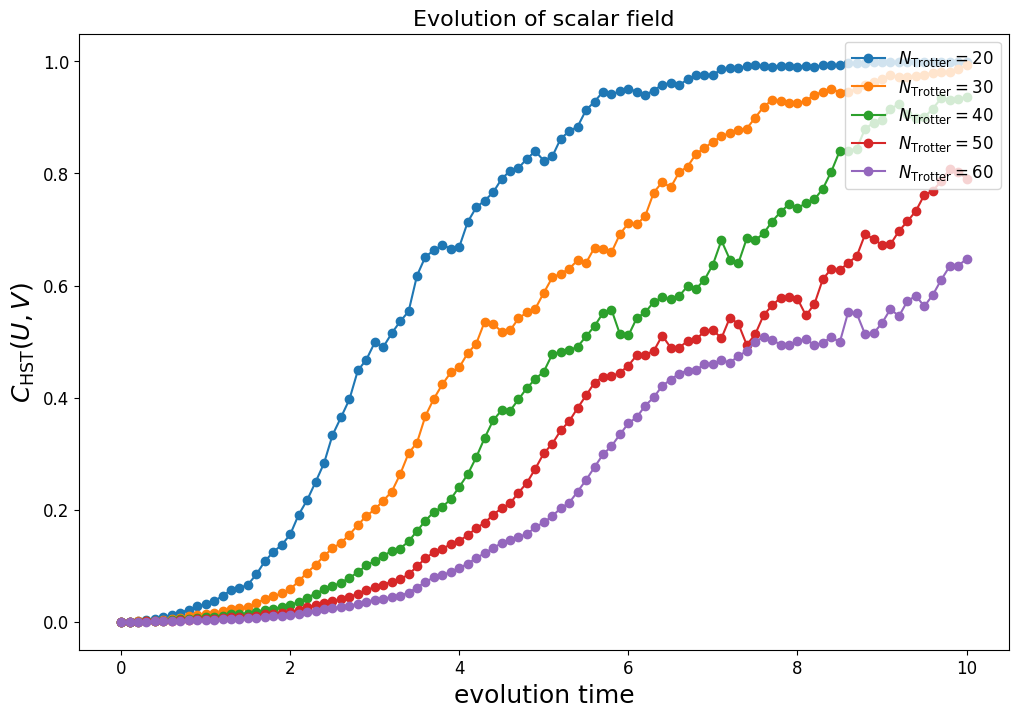

In [ ]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (12, 8)
for hs_cost, n_trotter in zip(hs_cost_lists, trotter_steps):
    plt.plot(ts, np.array(hs_cost), "-o", label="$N_\\text{Trotter} = $"+ str(n_trotter))

plt.title("Evolution of scalar field", size=16)
plt.xlabel("evolution time", size=18)
plt.ylabel("$C_\\text{HST}(U,V)$", size=18)
plt.tick_params("both", labelsize=12)
plt.legend(fontsize=12, loc="upper right")
plt.show()

It seems like this reduces the Hilbert-Schmidt cost. The inflection point for the cost-function curve moves beyond an evolution time of 5.0 when the number of Trotter steps is 60.

With reference to the devices we defined earlier, however, if we look at the circuit depth we find that

In [ ]:
print(f"The Trotterized circuit with 60 Trotter steps has depth {star_vm.analyze(trotter_state.circuit).depth} on the STAR device")
print(f"The Trotterized circuit with 60 Trotter steps has depth {nisq_vm.analyze(trotter_state.circuit).depth} on the NISQ device")

The Trotterized circuit with 60 Trotter steps has depth 7482 on the STAR device


The Trotterized circuit with 60 Trotter steps has depth 63145 on the NISQ device


### Noisy simulation using QURI VM

This will obviously be difficult to run with any reasonable fidelity. So how do we know if this could even work? Let's try to use a real device again with some finite physical error rate.

In [ ]:
n_trotter = 60
t = 5.0
p_phys_range = np.logspace(-6,-4,30)
trotter_evo_factory = DiscreteScalarFieldTrotterTimeEvoFactory(system, n_trotter)
trotter_circuit = trotter_evo_factory(t)

In [ ]:
fidelity = []
for p_phys in tqdm.tqdm(p_phys_range):
    logical_qubit_count = system.n_state_qubit
    star_property = star_device.generate_device_property(
        logical_qubit_count,
        code_distance=9,
        qec_cycle=TimeValue(1, TimeUnit.MICROSECOND),
        physical_error_rate=p_phys
    )
    star_vm = VM.from_device_prop(star_property)

    fidelity.append(star_vm.analyze(trotter_circuit).fidelity)

  0%|                                                                                         | 0/30 [00:00<?, ?it/s]

  3%|██▋                                                                              | 1/30 [00:01<00:57,  1.98s/it]

  7%|█████▍                                                                           | 2/30 [00:03<00:55,  1.97s/it]

 10%|████████                                                                         | 3/30 [00:05<00:53,  1.97s/it]

 13%|██████████▊                                                                      | 4/30 [00:07<00:51,  1.96s/it]

 17%|█████████████▌                                                                   | 5/30 [00:09<00:49,  1.97s/it]

 20%|████████████████▏                                                                | 6/30 [00:11<00:47,  1.97s/it]

 23%|██████████████████▉                                                              | 7/30 [00:13<00:45,  1.97s/it]

 27%|█████████████████████▌                                                           | 8/30 [00:15<00:43,  1.97s/it]

 30%|████████████████████████▎                                                        | 9/30 [00:17<00:41,  1.98s/it]

 33%|██████████████████████████▋                                                     | 10/30 [00:19<00:39,  1.97s/it]

 37%|█████████████████████████████▎                                                  | 11/30 [00:21<00:37,  1.97s/it]

 40%|████████████████████████████████                                                | 12/30 [00:23<00:35,  1.96s/it]

 43%|██████████████████████████████████▋                                             | 13/30 [00:25<00:33,  1.96s/it]

 47%|█████████████████████████████████████▎                                          | 14/30 [00:27<00:31,  1.95s/it]

 50%|████████████████████████████████████████                                        | 15/30 [00:29<00:29,  1.95s/it]

 53%|██████████████████████████████████████████▋                                     | 16/30 [00:31<00:27,  1.95s/it]

 57%|█████████████████████████████████████████████▎                                  | 17/30 [00:33<00:25,  1.95s/it]

 60%|████████████████████████████████████████████████                                | 18/30 [00:35<00:23,  1.95s/it]

 63%|██████████████████████████████████████████████████▋                             | 19/30 [00:37<00:21,  1.95s/it]

 67%|█████████████████████████████████████████████████████▎                          | 20/30 [00:39<00:19,  1.95s/it]

 70%|████████████████████████████████████████████████████████                        | 21/30 [00:41<00:17,  1.95s/it]

 73%|██████████████████████████████████████████████████████████▋                     | 22/30 [00:43<00:15,  1.96s/it]

 77%|█████████████████████████████████████████████████████████████▎                  | 23/30 [00:45<00:13,  1.96s/it]

 80%|████████████████████████████████████████████████████████████████                | 24/30 [00:47<00:11,  1.95s/it]

 83%|██████████████████████████████████████████████████████████████████▋             | 25/30 [00:48<00:09,  1.95s/it]

 87%|█████████████████████████████████████████████████████████████████████▎          | 26/30 [00:50<00:07,  1.95s/it]

 90%|████████████████████████████████████████████████████████████████████████        | 27/30 [00:52<00:05,  1.95s/it]

 93%|██████████████████████████████████████████████████████████████████████████▋     | 28/30 [00:54<00:03,  1.96s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 29/30 [00:56<00:01,  1.96s/it]

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:58<00:00,  1.96s/it]

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:58<00:00,  1.96s/it]

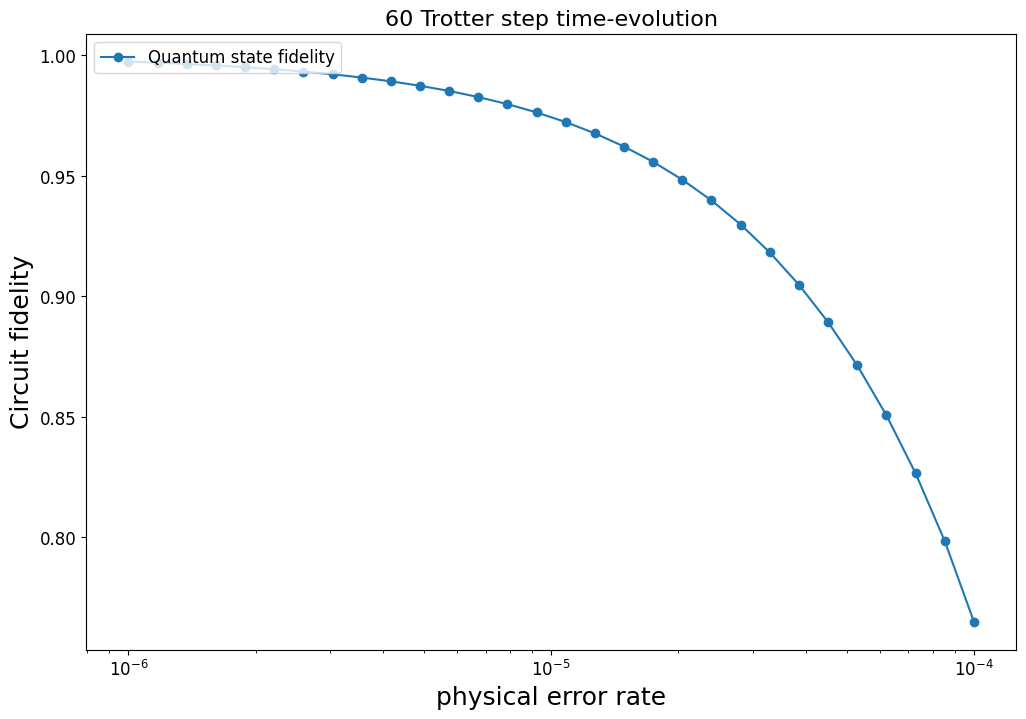

In [ ]:
plt.rcParams["figure.figsize"] = (12, 8)
plt.semilogx(p_phys_range, np.array(fidelity), "-o", label="Quantum state fidelity")

plt.title("60 Trotter step time-evolution", size=16)
plt.xlabel("physical error rate", size=18)
plt.ylabel("Circuit fidelity", size=18)
plt.tick_params("both", labelsize=12)
plt.legend(fontsize=12, loc="upper left")
plt.show()

With the partial error correction of the STAR architecture it appears that even for relatively high physical error rates we can still expect the quantum circuit to be executable in spite of its depth. Thus we have found a set of parameters where we can execute accurate time evolution using a quantum circuit representation of time-evolution for the scalar-field theory!

## Reference

[1] Andy C. Y. Li, Alexandru Macridin, Stephen Mrenna, Panagiotis Spentzouris. [Simulating scalar field theories on quantum computers with limited resources](https://arxiv.org/pdf/2210.07985)

[2] Alexandru Macridin, Andy C. Y. Li, Stephen Mrenna, Panagiotis Spentzouris. [Bosonic field digitization for quantum computers](https://arxiv.org/pdf/2108.10793)

[3] Yutaro Akahoshi, Kazunori Maruyama, Hirotaka Oshima, Shintaro Sato, Keisuke Fujii. [Partially Fault-tolerant Quantum Computing Architecture with Error-corrected Clifford Gates and Space-time Efficient Analog Rotations](https://arxiv.org/abs/2303.13181)